In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
)
from statannotations.Annotator import Annotator
from ripple_heterogeneity.replay import per_cell_contribution_example
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
import copy
import os
from nelpy.analysis import replay

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

## main analysis

In [6]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_example_v1"
)
replay_save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622"

batch_analysis.run(
    df,
    save_path,
    per_cell_contribution_example.run,
    parallel=True,
    verbose=True,
    replay_save_path=replay_save_path
)

100%|██████████| 309/309 [00:11<00:00, 26.87it/s]


In [3]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_example_v1"
)
results_df = batch_analysis.load_results(save_path=save_path)

## calculate difference scores

In [4]:
results_df["score_diff"] = results_df.scores_dropped - results_df.scores_obs
results_df["std_diff"] = results_df.std_dropped - results_df.std_obs

## plot the diff of replay score as a function of neurons dropped

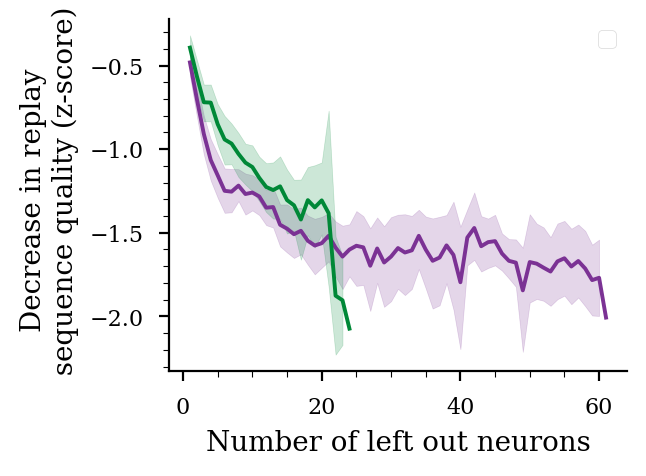

In [5]:
fig= plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1.25,1)), edgecolor=None)
ax = plt.gca()
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.lineplot(data=results_df, x="n_dropped", y="std_diff", hue="deepSuperficial",ax=ax)

ax.set_xlabel("Number of left out neurons")
ax.set_ylabel("Decrease in replay \n sequence quality (z-score)")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.legend("")
sns.despine()
plt.show()

In [7]:
results_df["n_dropped_norm"] = np.nan

for basepath in results_df.basepath.unique():
    current_df = results_df[(results_df.basepath == basepath) & (results_df.deepSuperficial == "Deep")].copy()
    if current_df.shape[0] > 0:
        ratio = current_df.n_dropped.values / current_df.n_deep.values
        results_df.loc[(results_df.basepath == basepath) & (results_df.deepSuperficial == "Deep"),"n_dropped_norm"] = ratio

    current_df = results_df[(results_df.basepath == basepath) & (results_df.deepSuperficial == "Superficial")].copy()
    if current_df.shape[0] > 0:
        ratio = current_df.n_dropped.values / current_df.n_sup.values
        results_df.loc[(results_df.basepath == basepath) & (results_df.deepSuperficial == "Superficial"),"n_dropped_norm"] = ratio


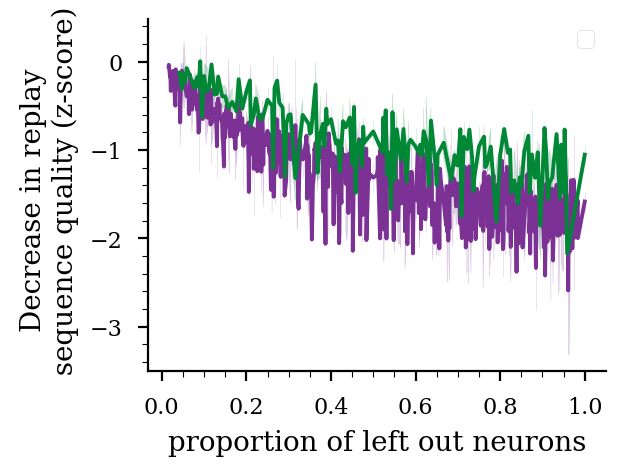

In [8]:
# results_df["n_dropped_norm"] = results_df.n_dropped / results_df.total_n_units

fig= plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1.25,1)), edgecolor=None)
ax = plt.gca()

sns.lineplot(data=results_df, x="n_dropped_norm", y="std_diff", hue="deepSuperficial",ax=ax)

ax.set_xlabel("proportion of left out neurons")
ax.set_ylabel("Decrease in replay \n sequence quality (z-score)")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.legend("")
sns.despine()
plt.show()

In [17]:
results_df

scores_dropped  std_dropped  scores_obs   std_obs  n_dropped   UID  \
0           0.499041     2.094194    0.522589  2.140820        1.0  34.0   
1           0.487393     2.064698    0.522589  2.140820        2.0  56.0   
2           0.485725     2.056112    0.522589  2.140820        3.0  58.0   
3           0.465449     2.008819    0.522589  2.140820        4.0  63.0   
4           0.470687     1.934810    0.522589  2.140820        5.0  69.0   
...              ...          ...         ...       ...        ...   ...   
1783        0.416328     1.290880    0.389179  1.688312        6.0  61.0   
1784        0.404675     0.470027    0.389179  1.688312        7.0  64.0   
1785        0.380385     0.964935    0.389179  1.688312        8.0  65.0   
1786        0.376948     0.703692    0.389179  1.688312        9.0  66.0   
1787        0.426616     1.377227    0.389179  1.688312       10.0  67.0   

     deepSuperficial putativeCellType  total_n_units  n_deep  n_sup  n_middle  \
0               Deep   Pyramidal Cell           41.0    22.0    5.0      14.0   
1               Deep   Pyramidal Cell           41.0    22.0    5.0      14.0   
2               Deep   Pyramidal Cell           41.0    22.0    5.0      14.0   
3               Deep   Pyramidal Cell           41.0    22.0    5.0      14.0   
4               Deep   Pyramidal Cell           41.0    22.0    5.0      14.0   
...              ...              ...            ...     ...    ...       ...   
1783     Superficial   Pyramidal Cell           23.0     7.0   10.0       6.0   
1784     Superficial   Pyramidal Cell           23.0     7.0   10.0       6.0   
1785     Superficial   Pyramidal Cell           23.0     7.0   10.0       6.0   
1786     Superficial   Pyramidal Cell           23.0     7.0   10.0       6.0   
1787     Superficial   Pyramidal Cell           23.0     7.0   10.0       6.0   

            direction                     basepath  score_diff  std_diff  \
0     outbound_epochs      Z:\Data\AYAold\AB1\day1   -0.023548 -0.046626   
1     outbound_epochs      Z:\Data\AYAold\AB1\day1   -0.035196 -0.076122   
2     outbound_epochs      Z:\Data\AYAold\AB1\day1   -0.036864 -0.084709   
3     outbound_epochs      Z:\Data\AYAold\AB1\day1   -0.057140 -0.132001   
4     outbound_epochs      Z:\Data\AYAold\AB1\day1   -0.051902 -0.206010   
...               ...                          ...         ...       ...   
1783  outbound_epochs  Z:\Data\Kenji\ec016.267_278    0.027149 -0.397433   
1784  outbound_epochs  Z:\Data\Kenji\ec016.267_278    0.015496 -1.218285   
1785  outbound_epochs  Z:\Data\Kenji\ec016.267_278   -0.008794 -0.723377   
1786  outbound_epochs  Z:\Data\Kenji\ec016.267_278   -0.012231 -0.984620   
1787  outbound_epochs  Z:\Data\Kenji\ec016.267_278    0.037437 -0.311085   

      n_dropped_norm  
0           0.045455  
1           0.090909  
2           0.136364  
3           0.181818  
4           0.227273  
...              ...  
1783        0.600000  
1784        0.700000  
1785        0.800000  
1786        0.900000  
1787        1.000000  

[1788 rows x 17 columns]

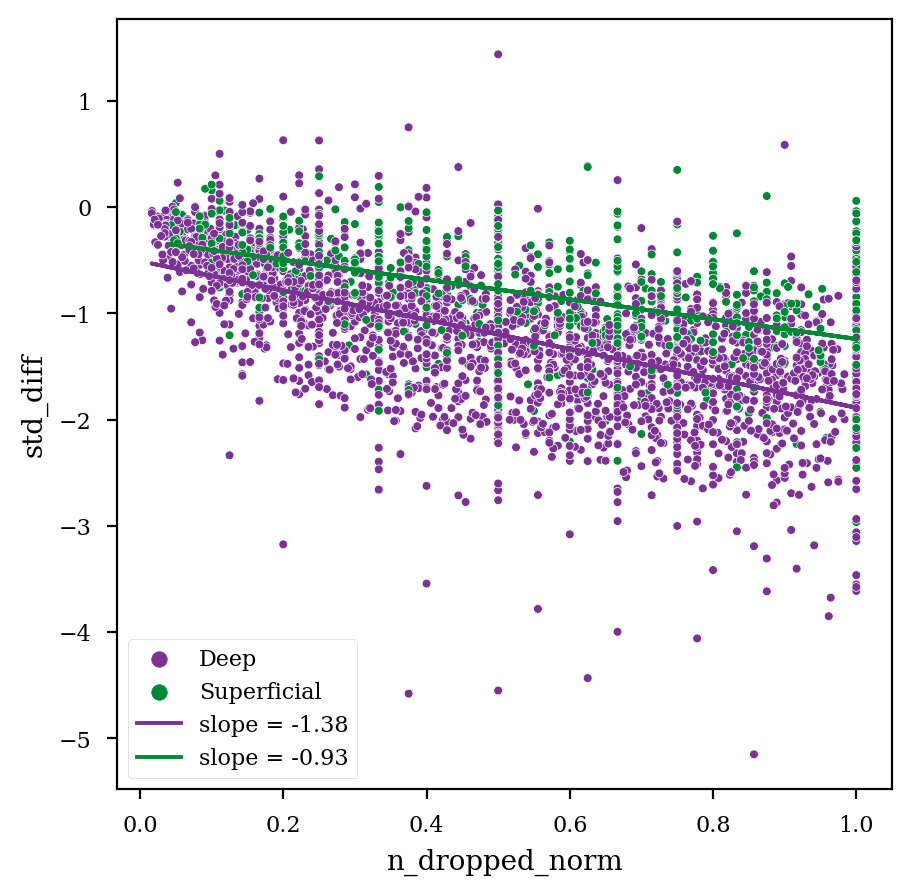

In [42]:
from sklearn.linear_model import LinearRegression
results_df.replace([np.inf, -np.inf], np.nan, inplace=True)

def get_regression(X, y):
    bad_idx = np.isnan(X) | np.isnan(y)
    X = X[~bad_idx].reshape(-1, 1)
    y = y[~bad_idx]
    reg = LinearRegression()
    reg.fit(X, y)

    return reg

plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=results_df.query("not n_dropped_norm.isnull() | not std_diff.isnull()"),
    x="n_dropped_norm",
    y="std_diff",
    hue="deepSuperficial",
    s=10
)
reg = get_regression(
    results_df.query("deepSuperficial=='Deep'").n_dropped_norm.values,
    results_df.query("deepSuperficial=='Deep'").std_diff.values,
)
plt.plot(
    results_df.query("deepSuperficial=='Deep'").n_dropped_norm,
    results_df.query("deepSuperficial=='Deep'").n_dropped_norm * reg.coef_
    + reg.intercept_,label=f"slope = {reg.coef_[0] :.2f}"
)

reg = get_regression(
    results_df.query("deepSuperficial=='Superficial'").n_dropped_norm.values,
    results_df.query("deepSuperficial=='Superficial'").std_diff.values,
)
plt.plot(
    results_df.query("deepSuperficial=='Superficial'").n_dropped_norm,
    results_df.query("deepSuperficial=='Superficial'").n_dropped_norm * reg.coef_
    + reg.intercept_,label=f"slope = {reg.coef_[0] :.2f}"
)
plt.legend()

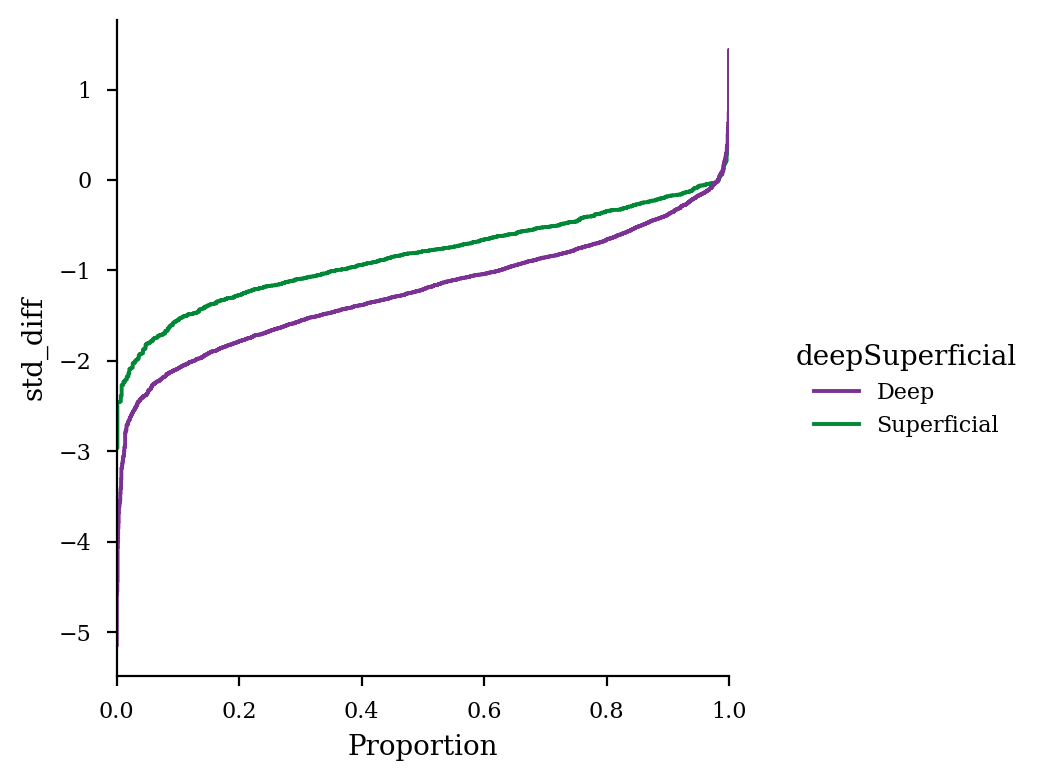

In [39]:
sns.displot(
    data=results_df, y="std_diff", hue="deepSuperficial",
    kind="ecdf", height=4, aspect=1,
)

In [ ]:
X.reshape(-1, 1)

In [88]:
y = results_df.query("basepath==@basepath & deepSuperficial=='Superficial'").std_diff.values
X = results_df.query("basepath==@basepath & deepSuperficial=='Superficial'").n_dropped_norm.values
X = np.vstack([X,X**2]).T
X

reg = LinearRegression().fit(X, y)
reg.intercept_,reg.coef_
# reg = get_regression(X,y)

(0.3479965072896791, array([-5.37815034,  3.18301323]))

In [91]:
reg.intercept_ + (X[:,0] * reg.coef_[0]) + (X[:,1] * reg.coef_[1])

array([ 0.08704652, -0.15798839, -0.38710825, -0.60031303, -0.79760275,
       -0.97897741, -1.14443699, -1.29398151, -1.42761097, -1.54532536,
       -1.64712468, -1.73300894, -1.80297813, -1.85703225, -1.89517131,
       -1.9173953 , -1.92370423, -1.91409809, -1.88857688, -1.84714061,
        0.12943297, -0.07807843, -0.2745377 , -0.45994485, -0.63429987,
       -0.79760275, -0.94985351, -1.09105214, -1.22119864, -1.34029301,
       -1.44833525, -1.54532536, -1.63126334, -1.70614919, -1.76998292,
       -1.82276451, -1.86449397, -1.89517131, -1.91479652, -1.92336959,
       -1.92089054, -1.90735936, -1.88277605, -1.84714061])

In [94]:
X

array([[0.05      , 0.0025    ],
       [0.1       , 0.01      ],
       [0.15      , 0.0225    ],
       [0.2       , 0.04      ],
       [0.25      , 0.0625    ],
       [0.3       , 0.09      ],
       [0.35      , 0.1225    ],
       [0.4       , 0.16      ],
       [0.45      , 0.2025    ],
       [0.5       , 0.25      ],
       [0.55      , 0.3025    ],
       [0.6       , 0.36      ],
       [0.65      , 0.4225    ],
       [0.7       , 0.49      ],
       [0.75      , 0.5625    ],
       [0.8       , 0.64      ],
       [0.85      , 0.7225    ],
       [0.9       , 0.81      ],
       [0.95      , 0.9025    ],
       [1.        , 1.        ],
       [0.04166667, 0.00173611],
       [0.08333333, 0.00694444],
       [0.125     , 0.015625  ],
       [0.16666667, 0.02777778],
       [0.20833333, 0.04340278],
       [0.25      , 0.0625    ],
       [0.29166667, 0.08506944],
       [0.33333333, 0.11111111],
       [0.375     , 0.140625  ],
       [0.41666667, 0.17361111],
       [0.

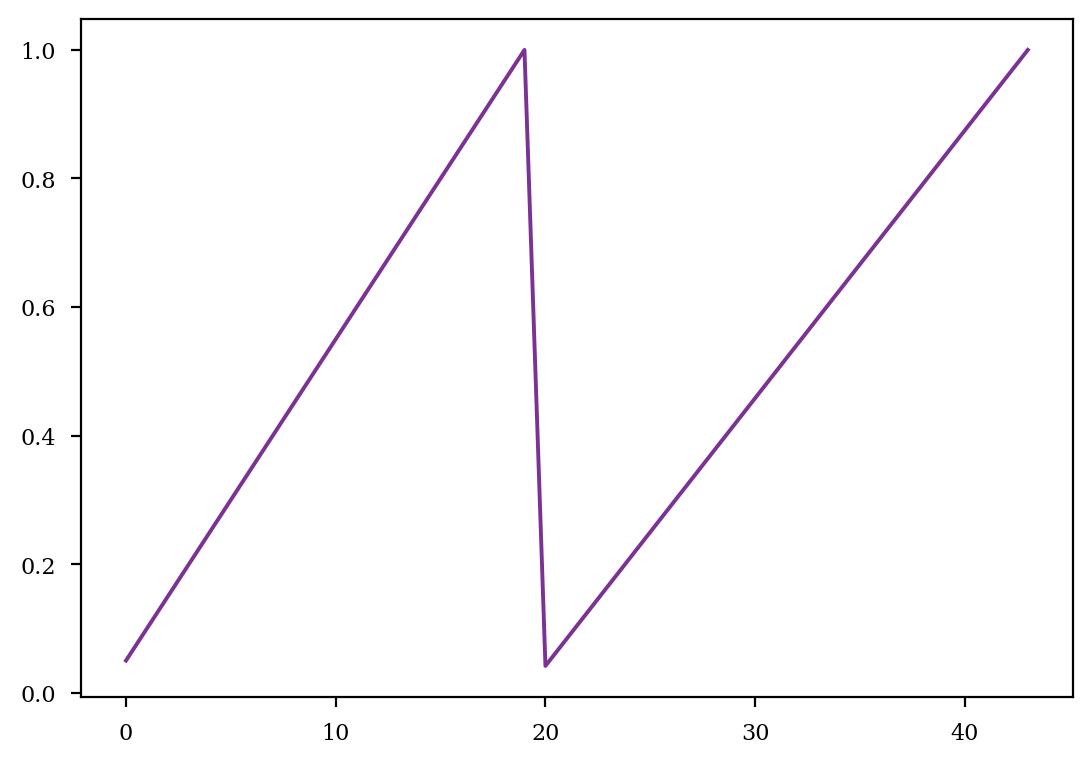

In [103]:
plt.plot(X[:,0])

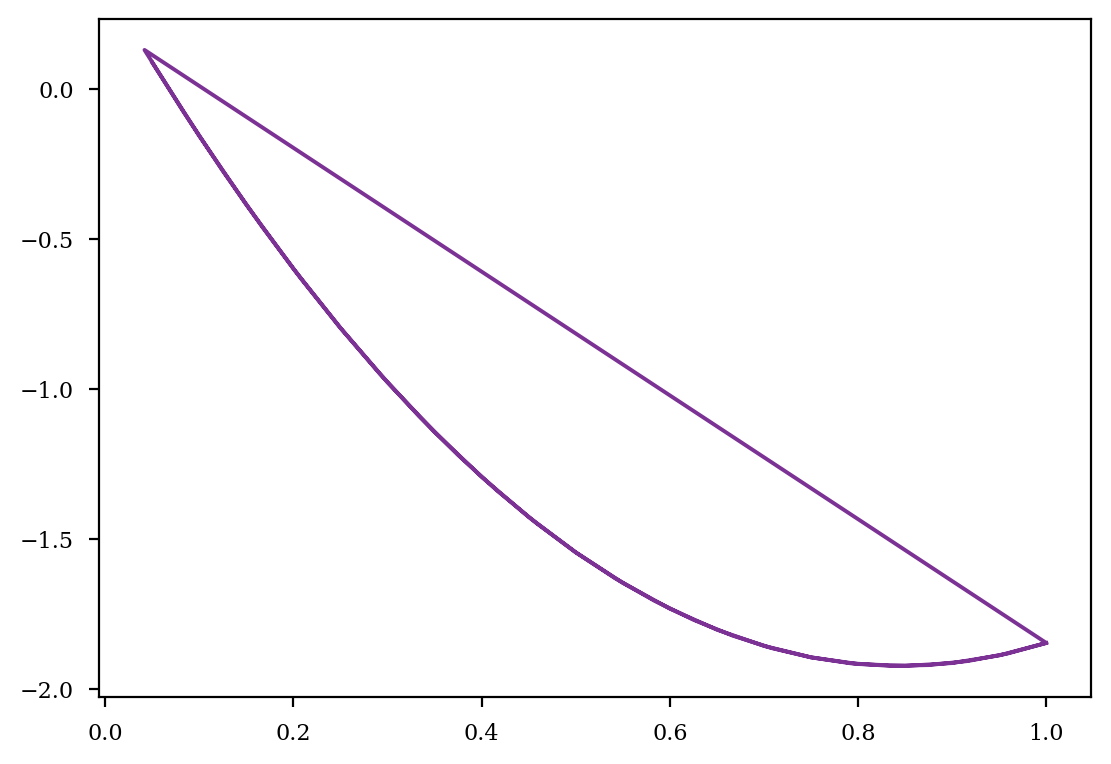

In [100]:
plt.plot(
    X[:,0],
    reg.intercept_ + (X[:,0] * reg.coef_[0]) + (X[:,1] * reg.coef_[1]),
)

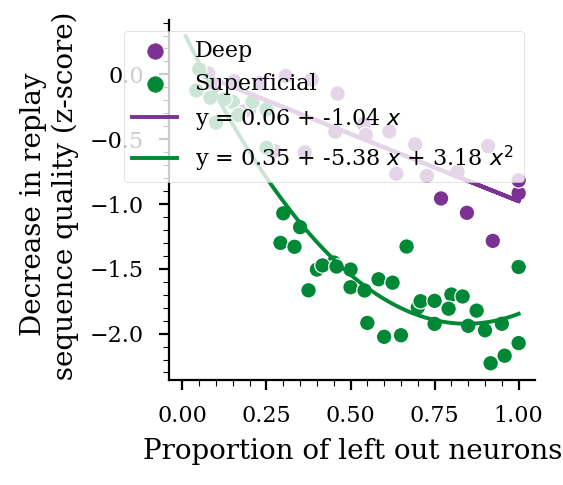

In [108]:
basepath = r"Z:\Data\AYAold\AB3\AB3_58_59"
fig= plt.figure(figsize=functions.set_size("thesis", fraction=.4, subplots=(1.6,1)), edgecolor=None)
ax = plt.gca()

# sns.lineplot(data=results_df.query("basepath==@basepath"), x="n_dropped_norm", y="std_diff", hue="deepSuperficial",ax=ax)
sns.scatterplot(data=results_df.query("basepath==@basepath"), x="n_dropped_norm", y="std_diff", hue="deepSuperficial",ax=ax)

reg = get_regression(
    results_df.query("basepath==@basepath & deepSuperficial=='Deep'").n_dropped_norm.values,
    results_df.query("basepath==@basepath & deepSuperficial=='Deep'").std_diff.values,
)
plt.plot(
    results_df.query("basepath==@basepath & deepSuperficial=='Deep'").n_dropped_norm,
    results_df.query("basepath==@basepath & deepSuperficial=='Deep'").n_dropped_norm * reg.coef_
    + reg.intercept_,label=f"y = {reg.intercept_:.2f} + {reg.coef_[0]:.2f} ${{x}}$ "
)

y = results_df.query("basepath==@basepath & deepSuperficial=='Superficial'").std_diff.values
X = results_df.query("basepath==@basepath & deepSuperficial=='Superficial'").n_dropped_norm.values
X = np.vstack([X,X**2]).T
reg = LinearRegression().fit(X, y)
X = np.arange(.01,1.01,.01)
X = np.vstack([X,X**2]).T
plt.plot(
    X[:,0],
    reg.intercept_ + (X[:,0] * reg.coef_[0]) + (X[:,1] * reg.coef_[1]),
    label=f"y = {reg.intercept_:.2f} + {reg.coef_[0]:.2f} ${{x}}$ + {reg.coef_[1]:.2f} ${{x^2}}$ "
)

ax.set_xlabel("Proportion of left out neurons")
ax.set_ylabel("Decrease in replay \n sequence quality (z-score)")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
sns.despine()

plt.savefig(
    os.path.join(fig_save_path, "per_cell_replay_contribution_example.svg"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

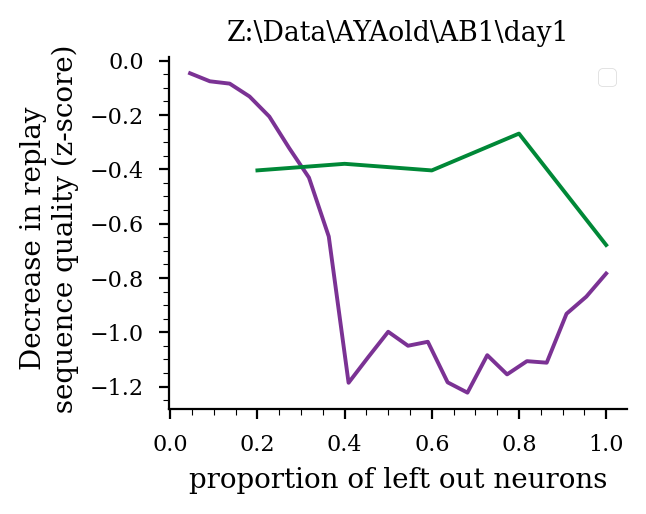

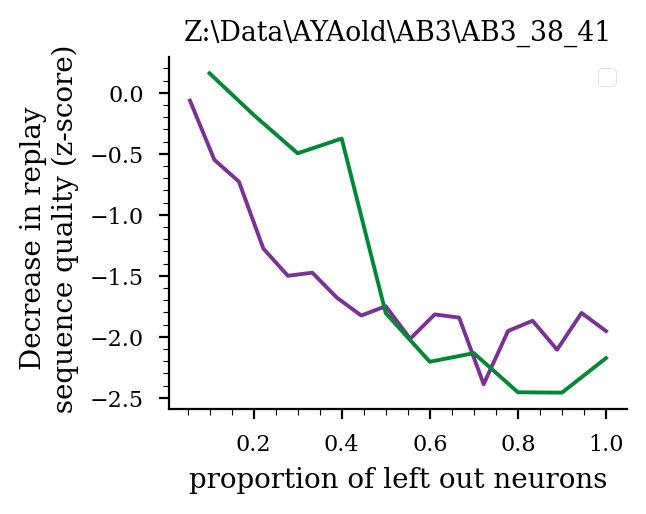

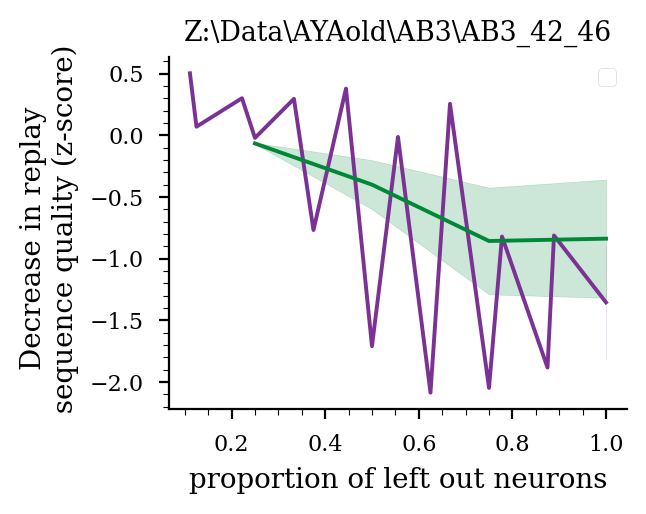

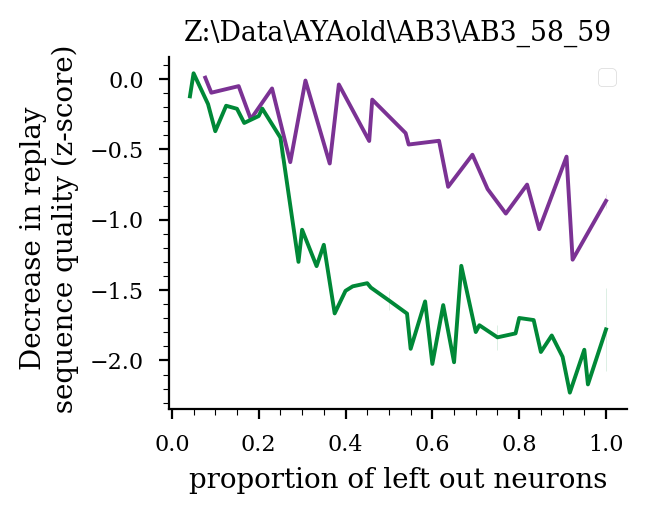

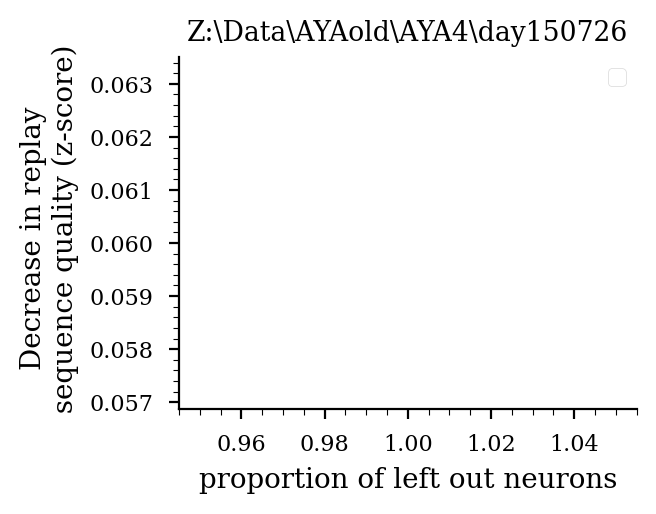

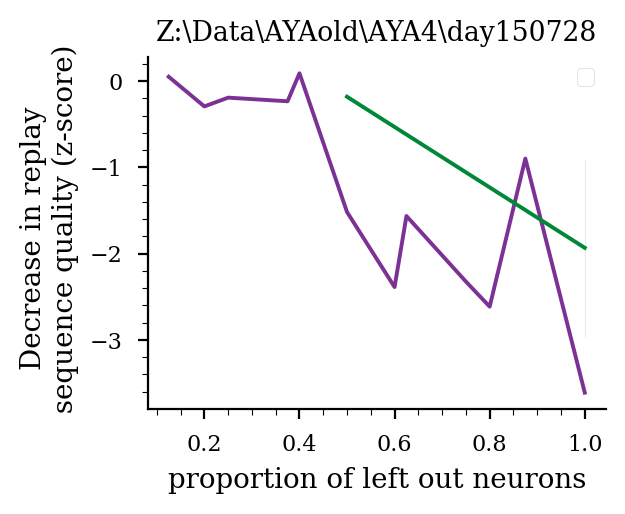

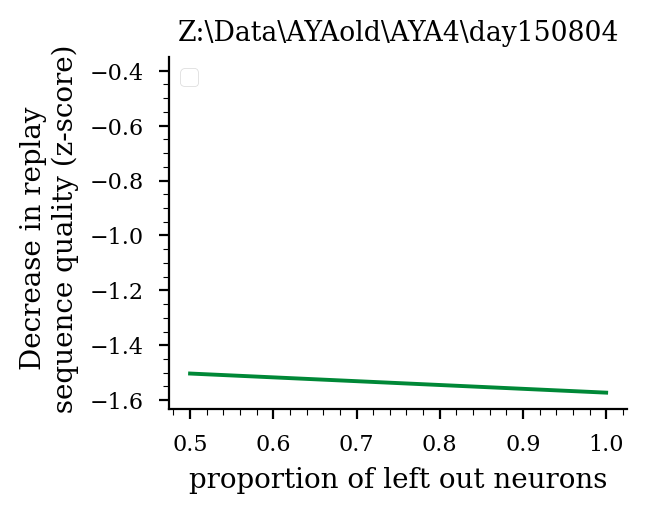

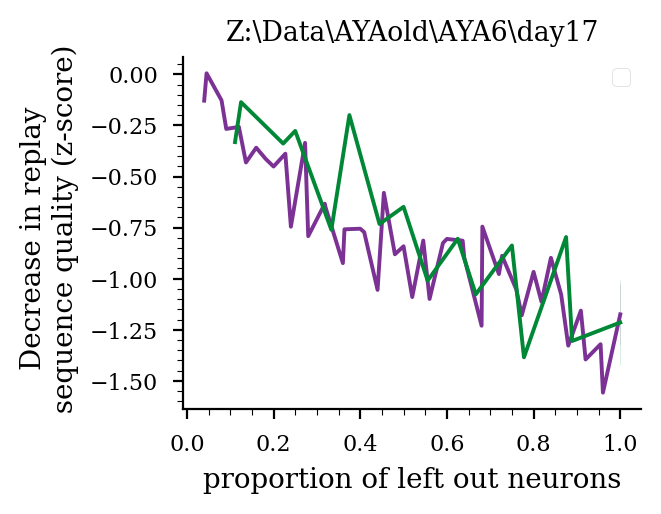

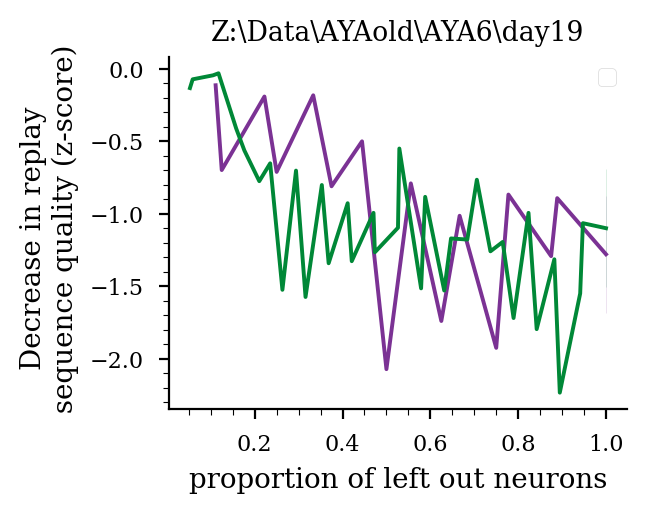

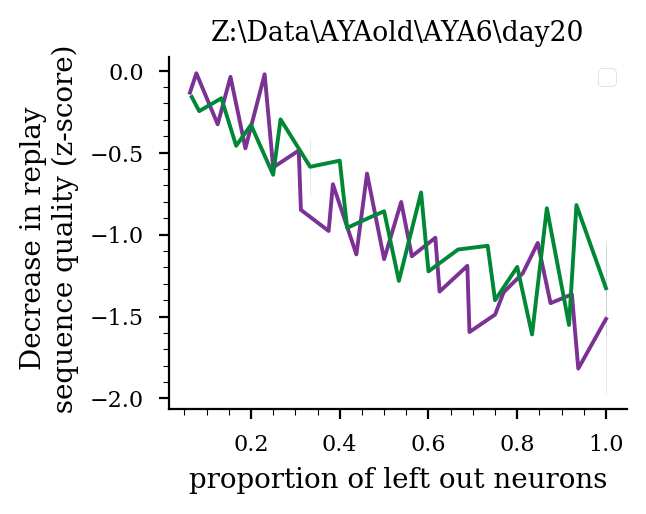

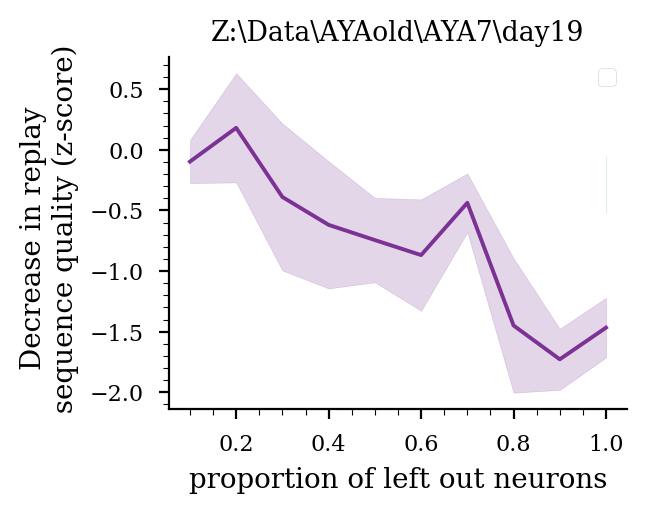

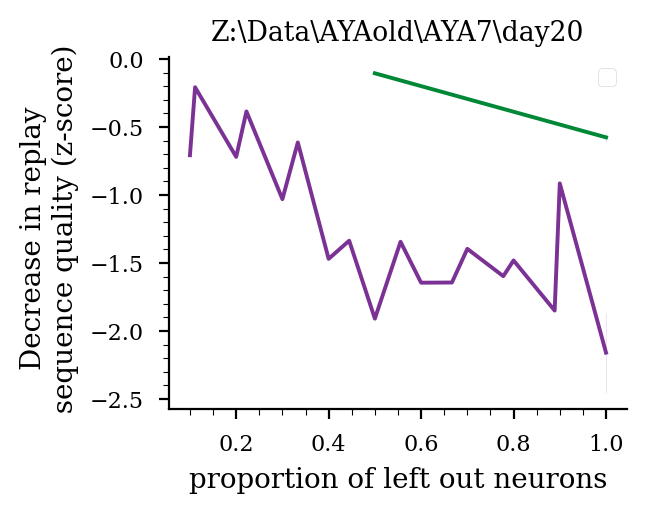

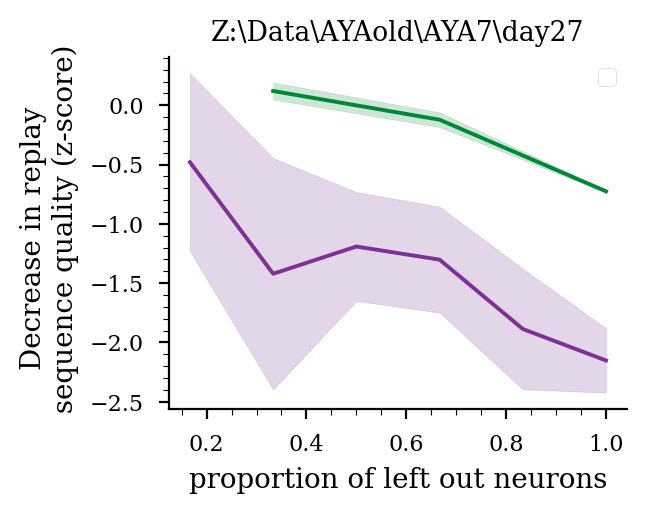

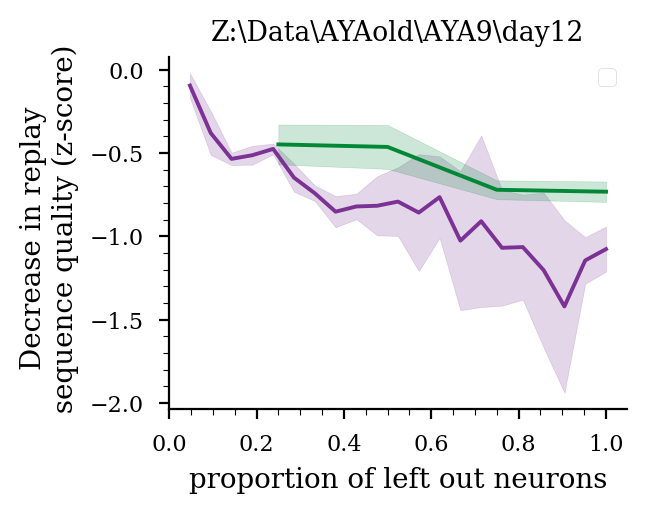

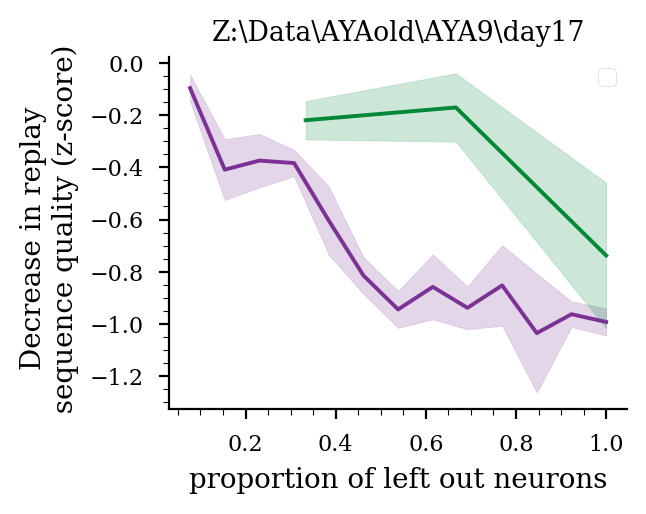

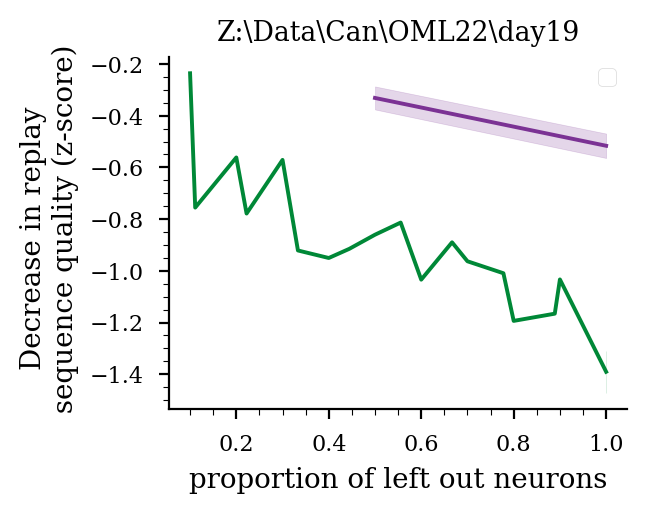

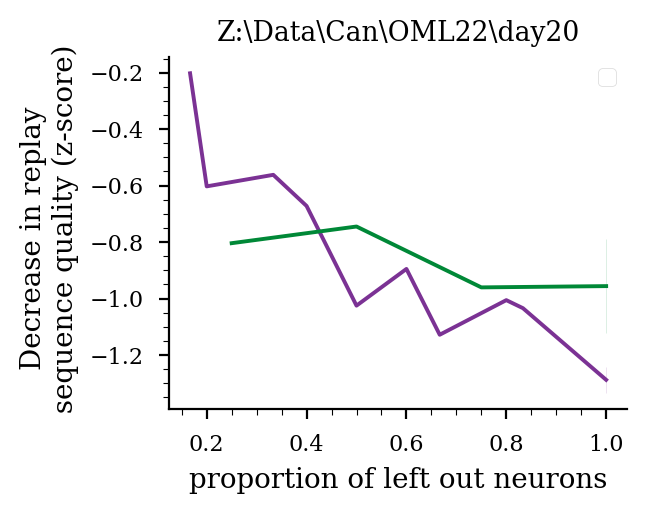

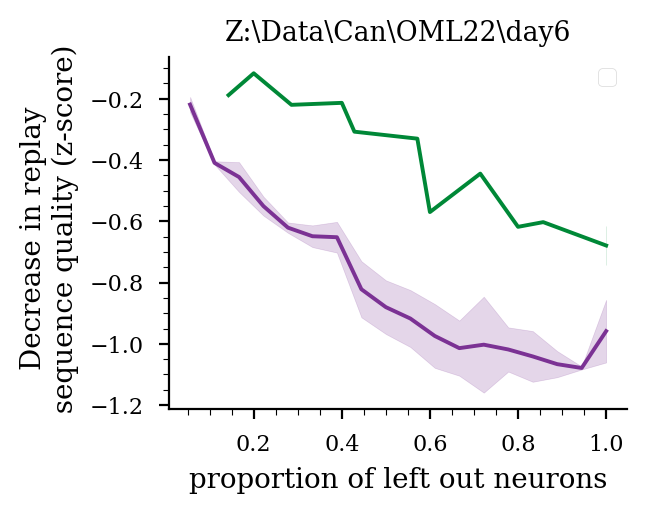

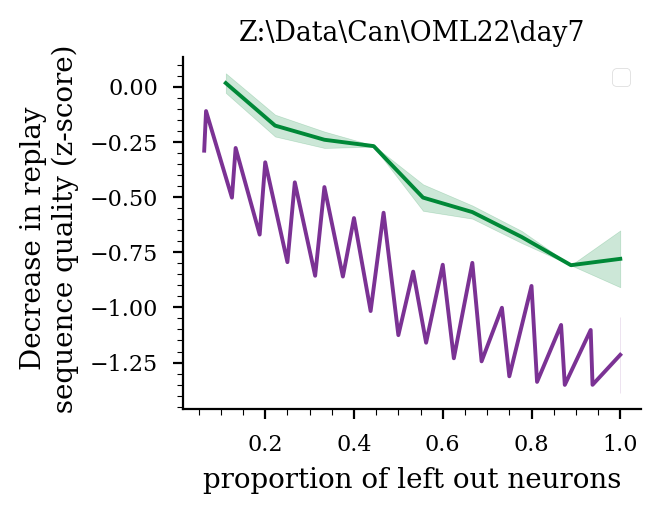

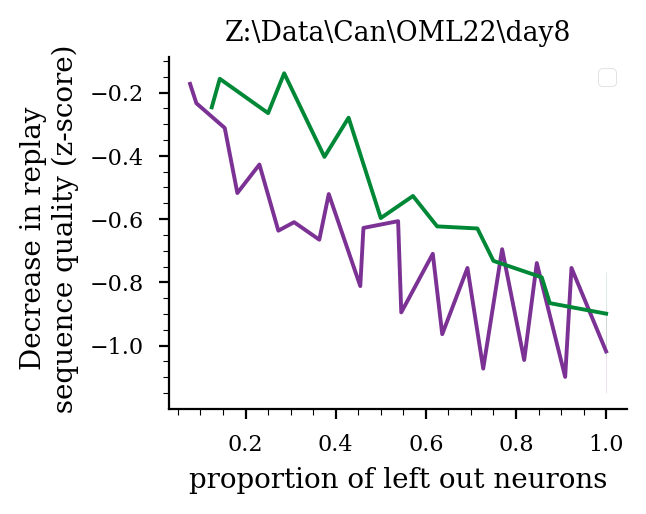

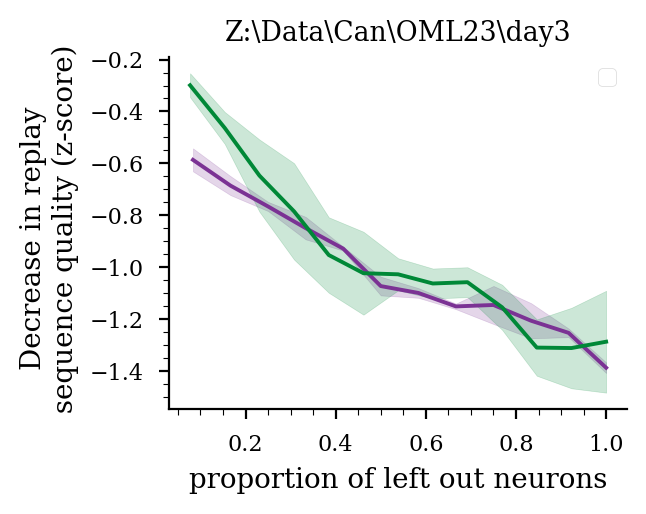

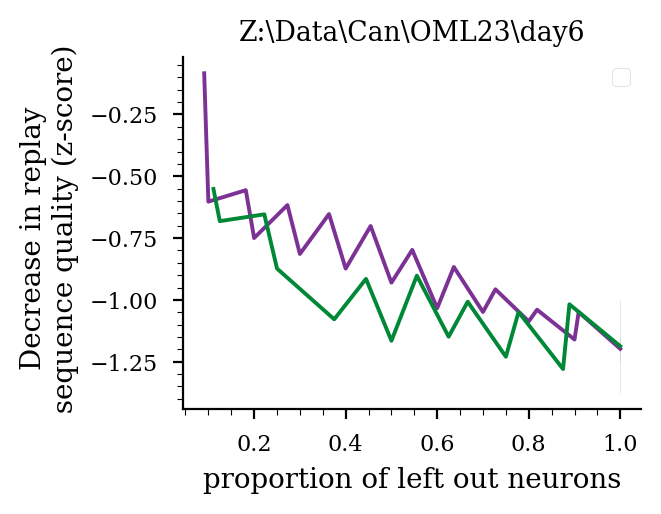

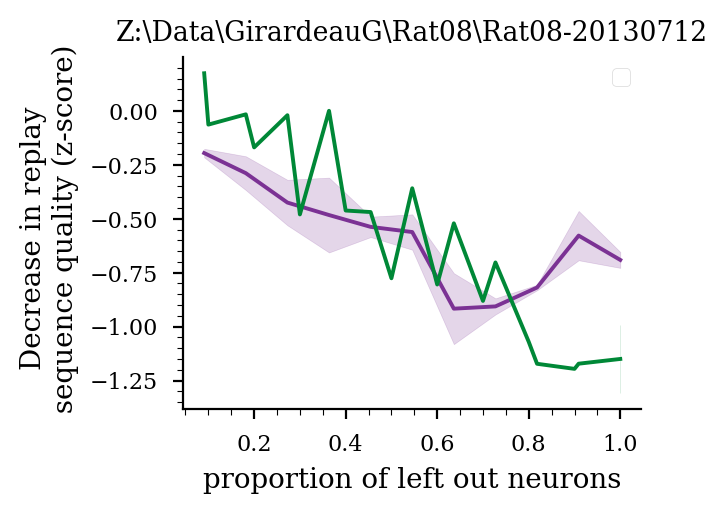

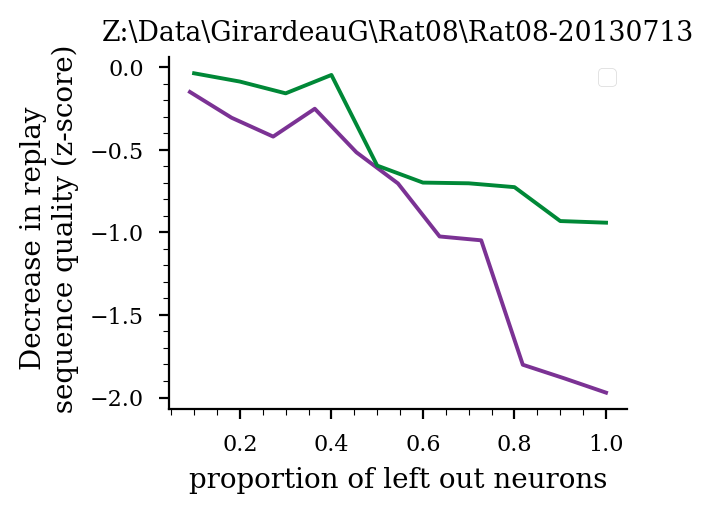

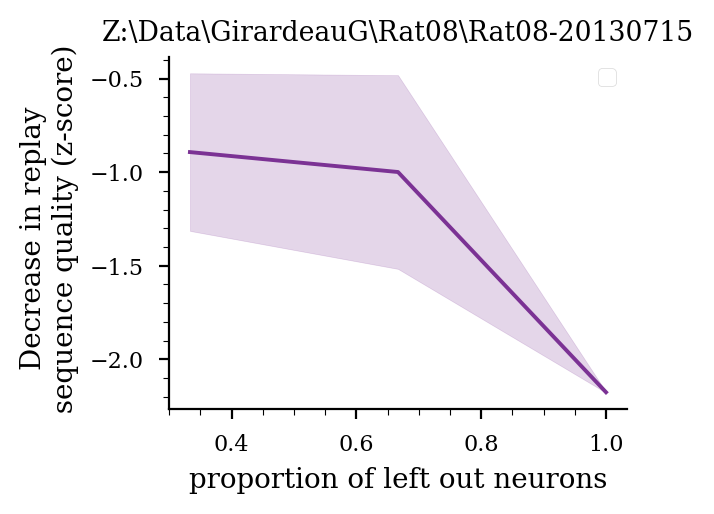

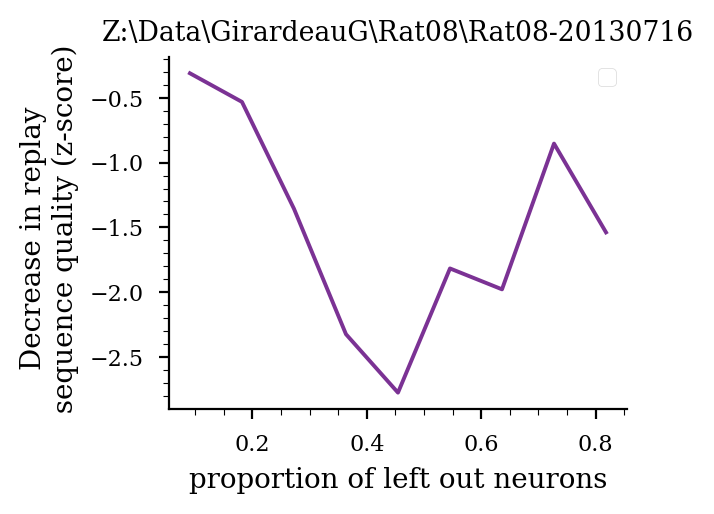

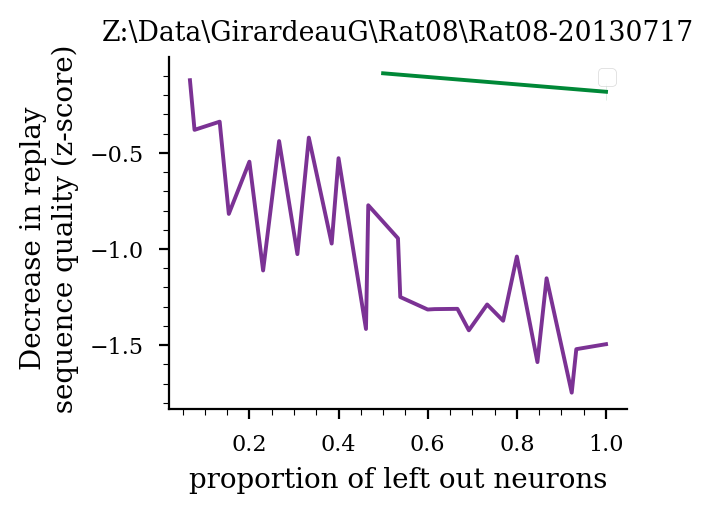

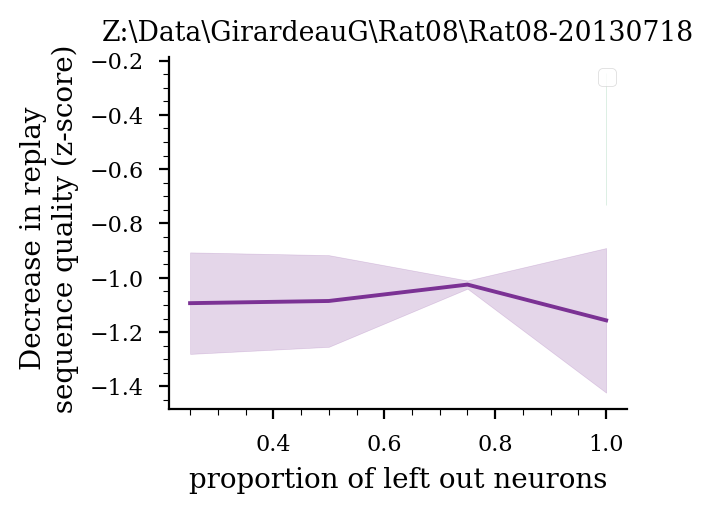

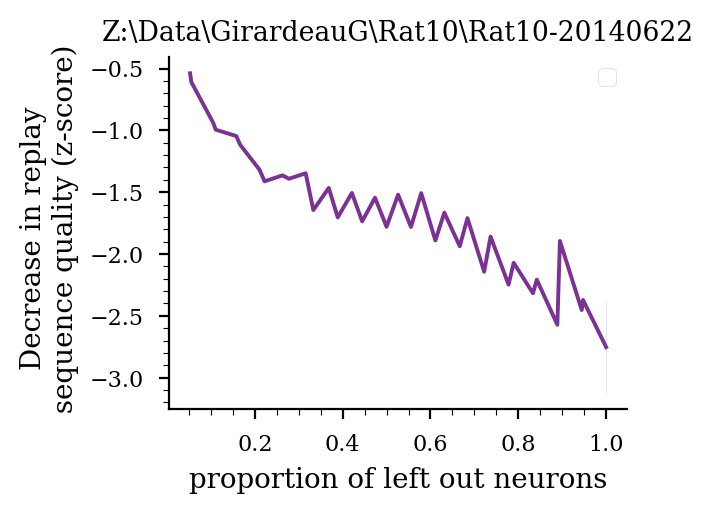

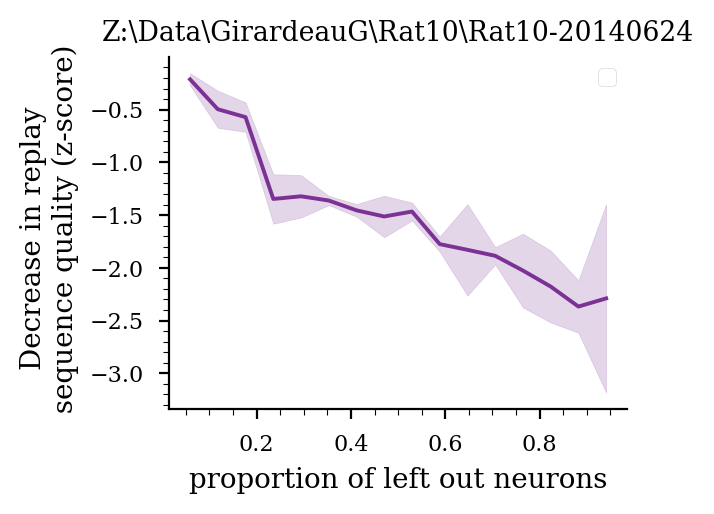

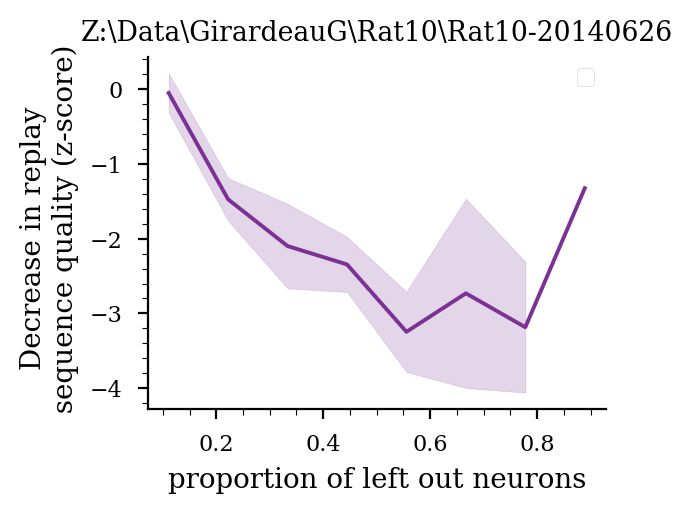

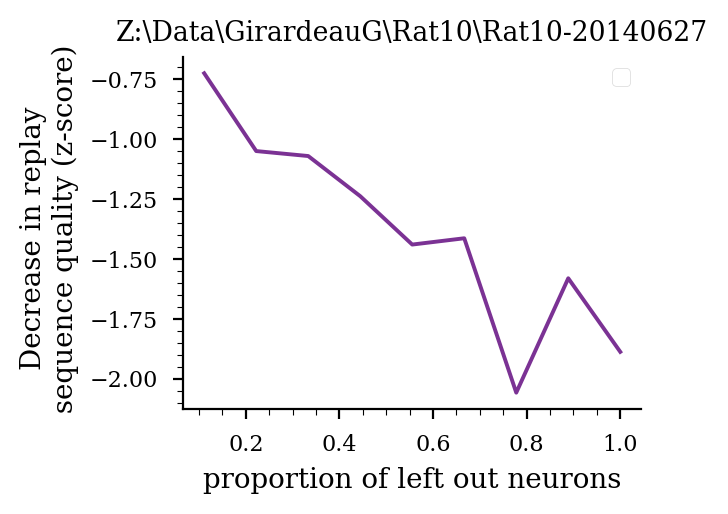

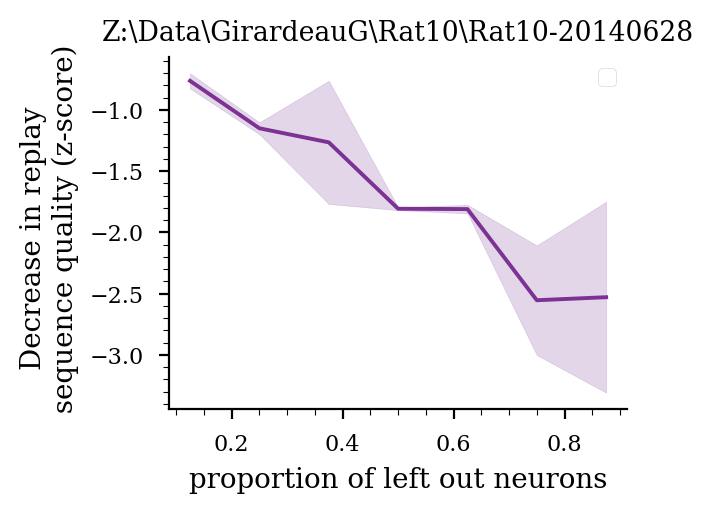

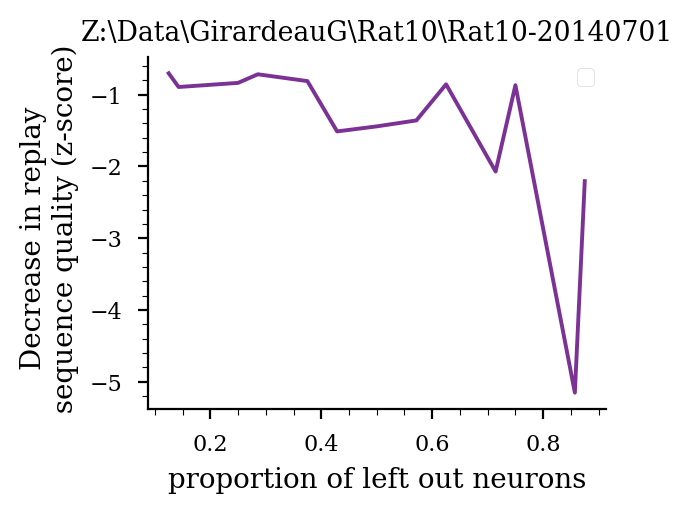

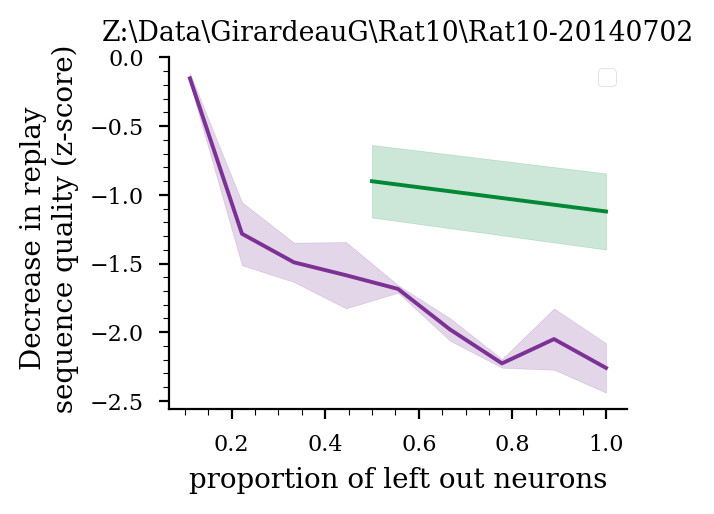

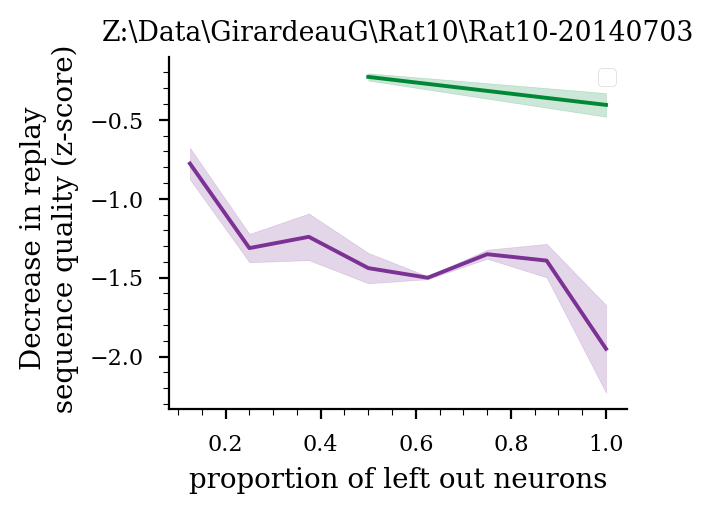

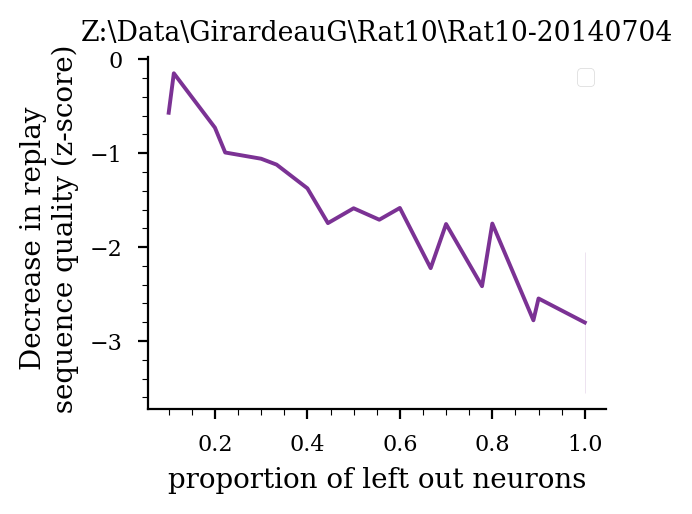

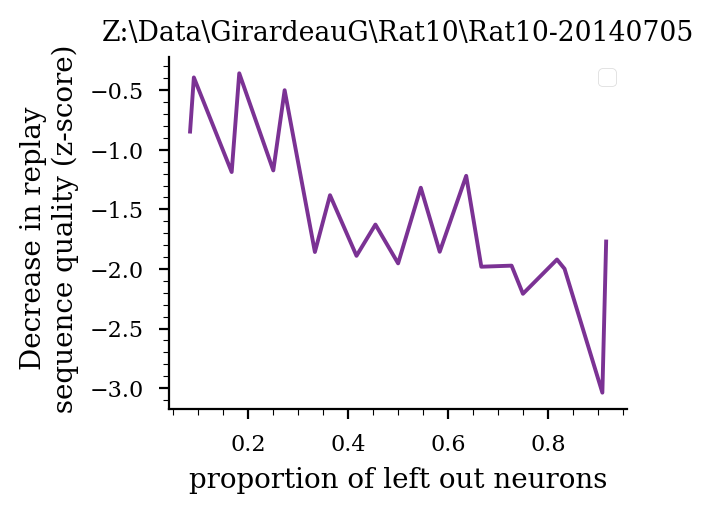

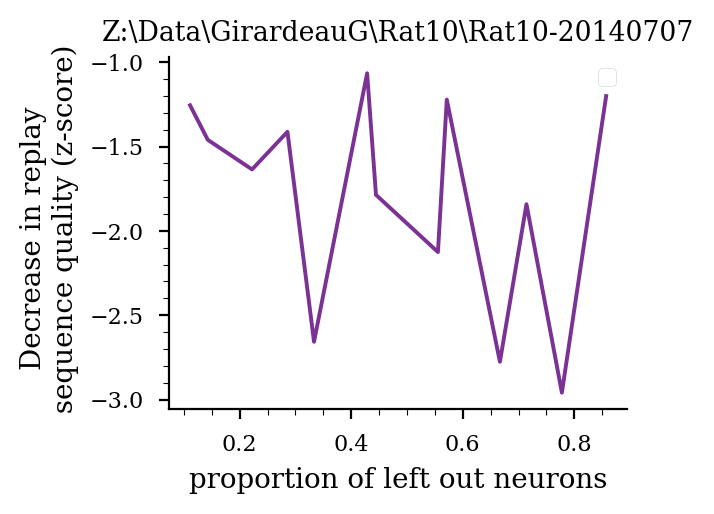

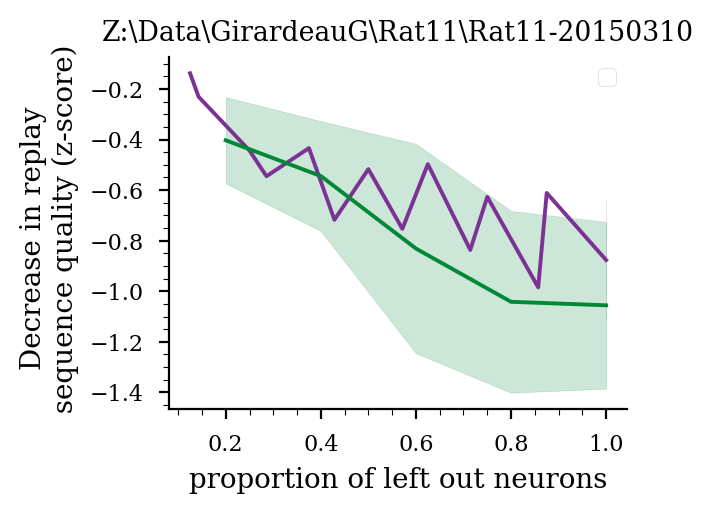

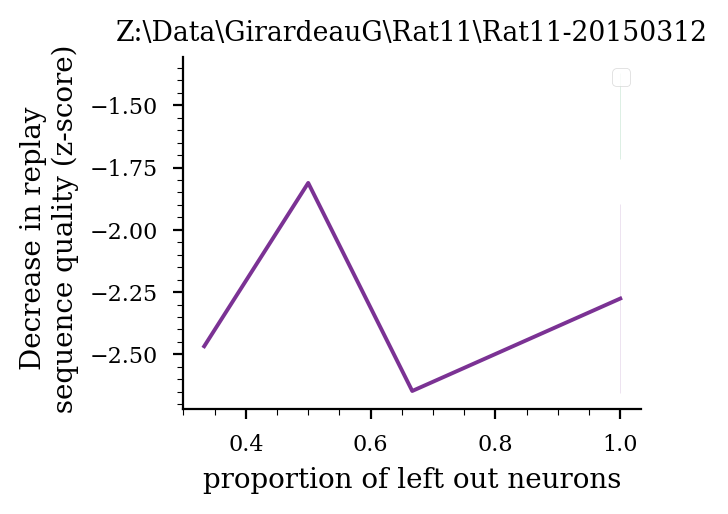

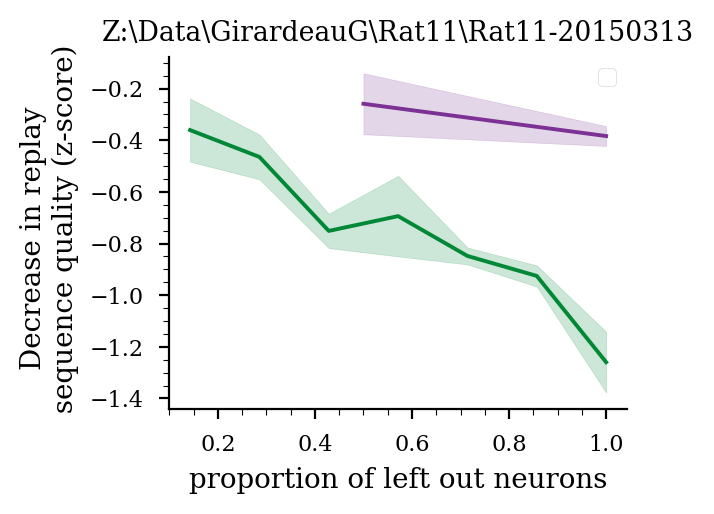

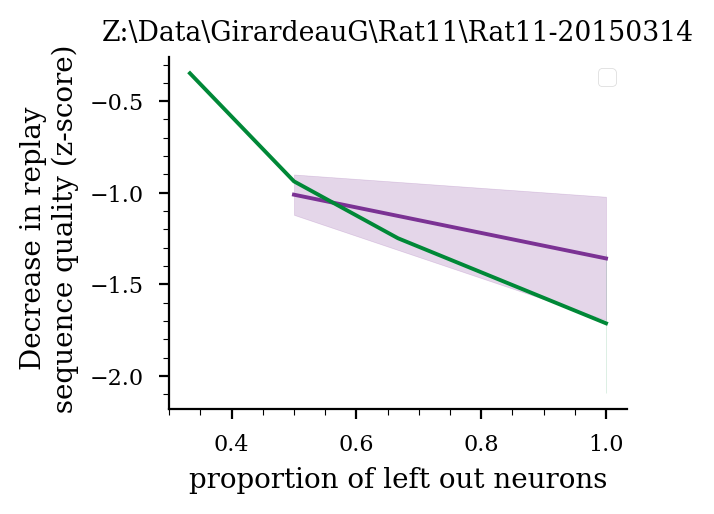

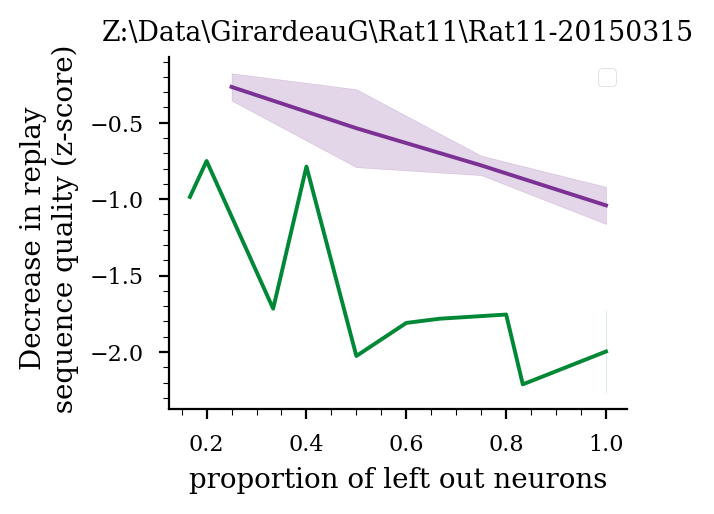

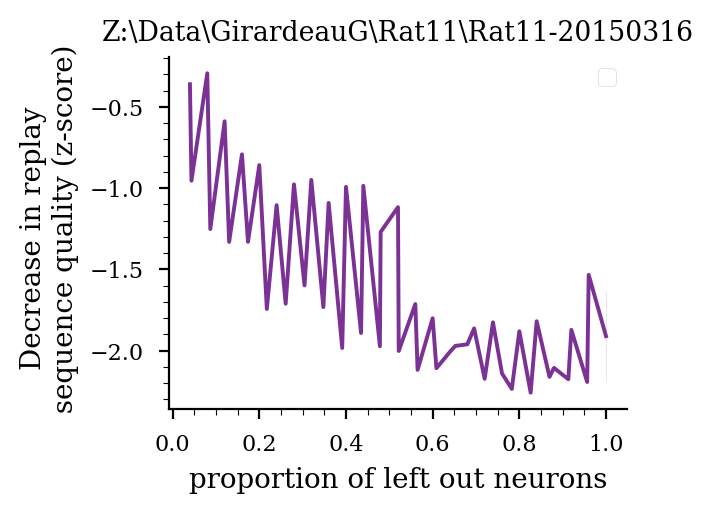

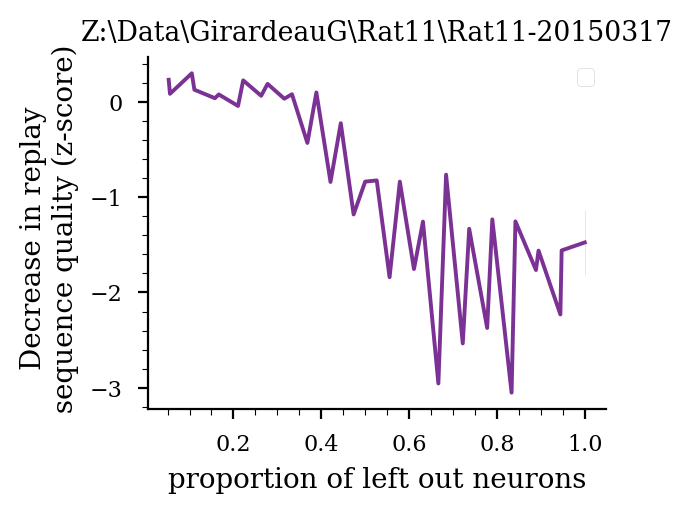

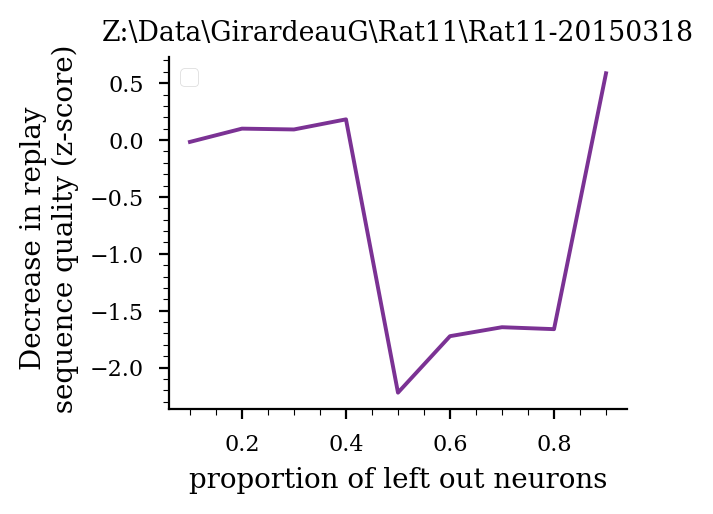

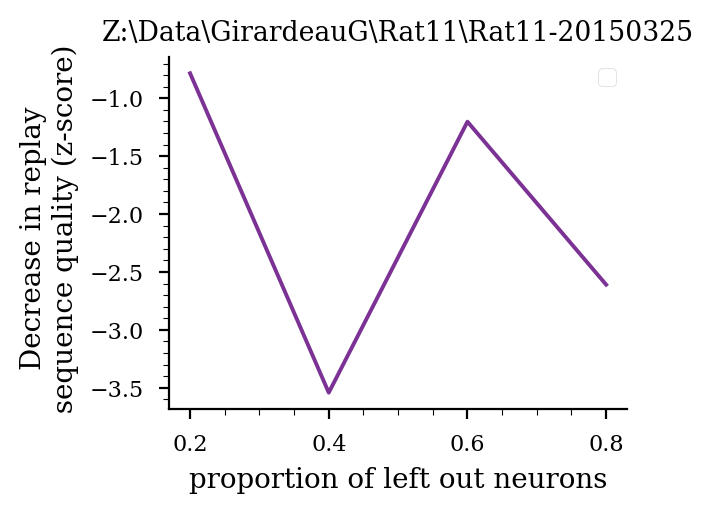

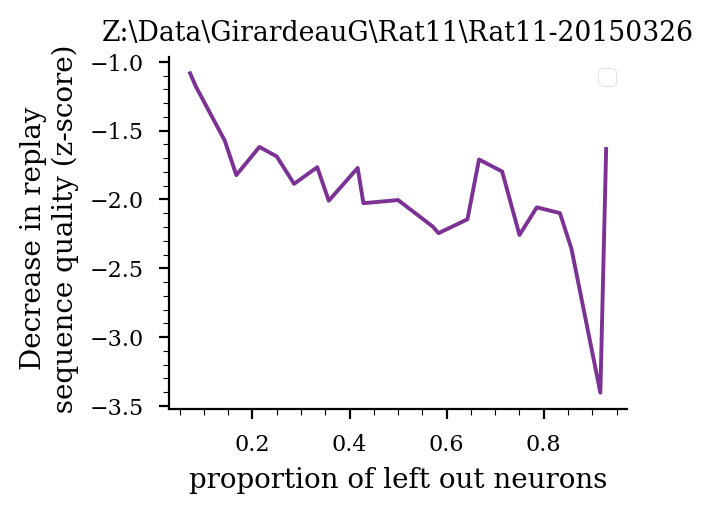

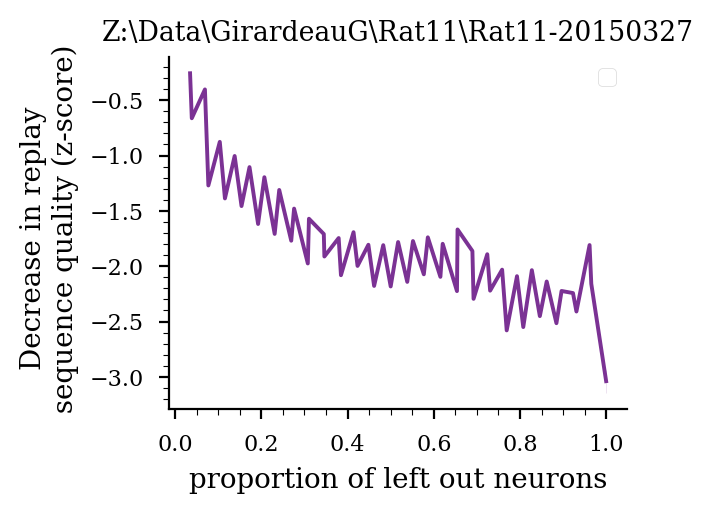

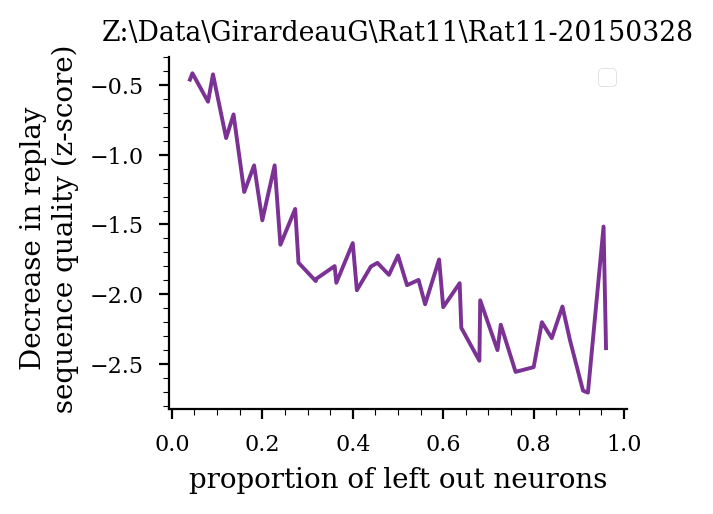

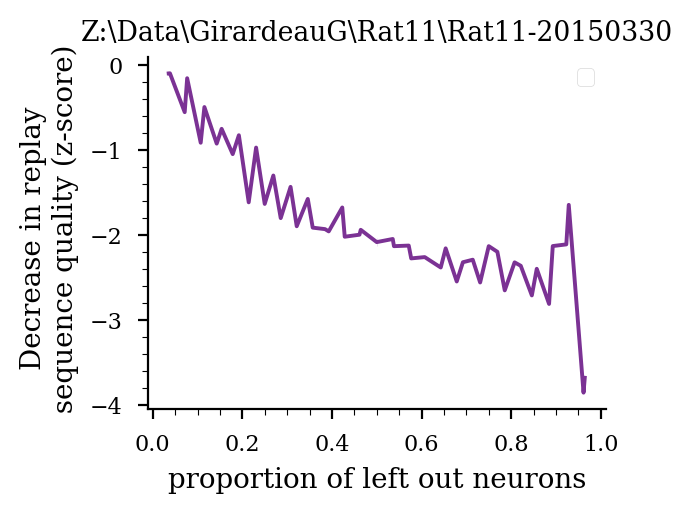

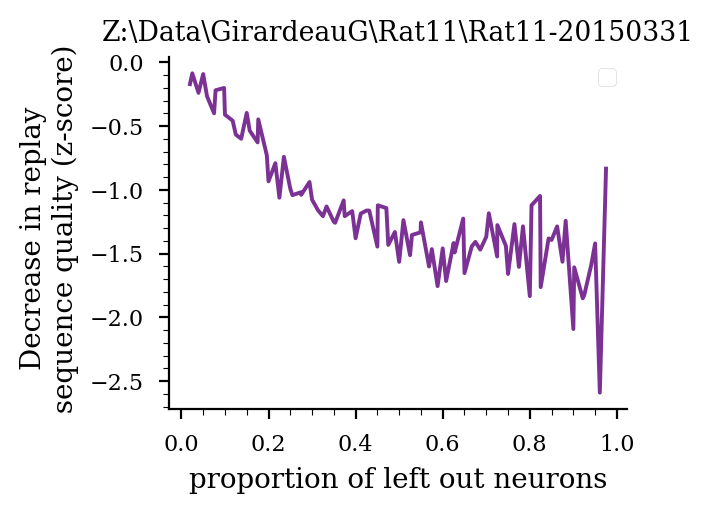

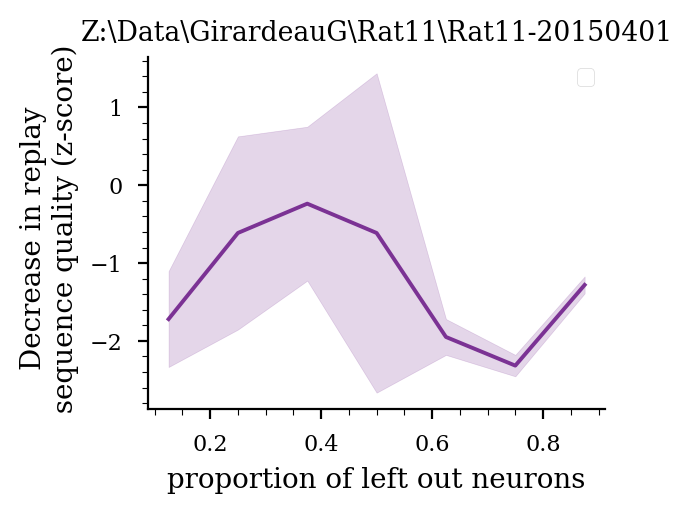

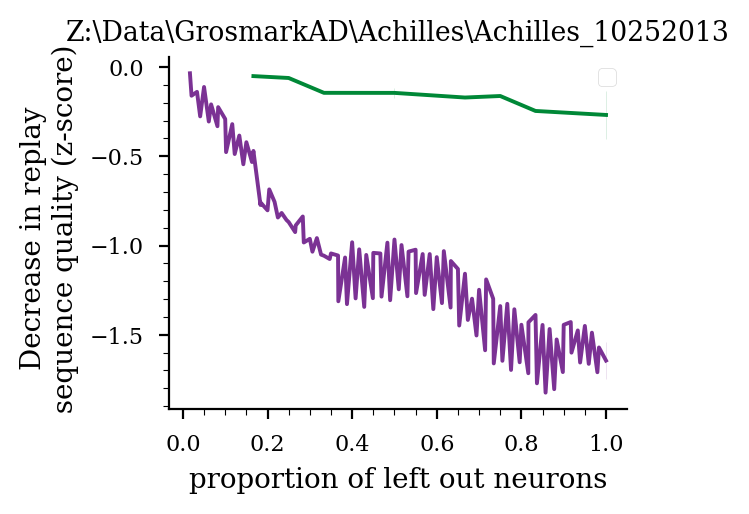

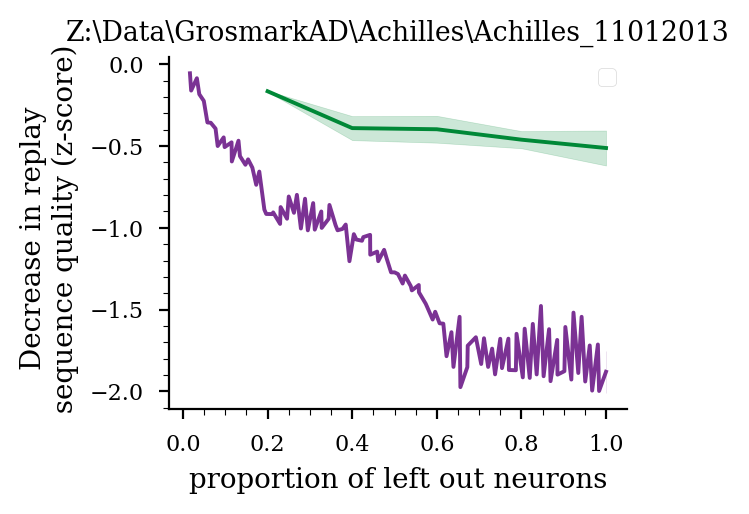

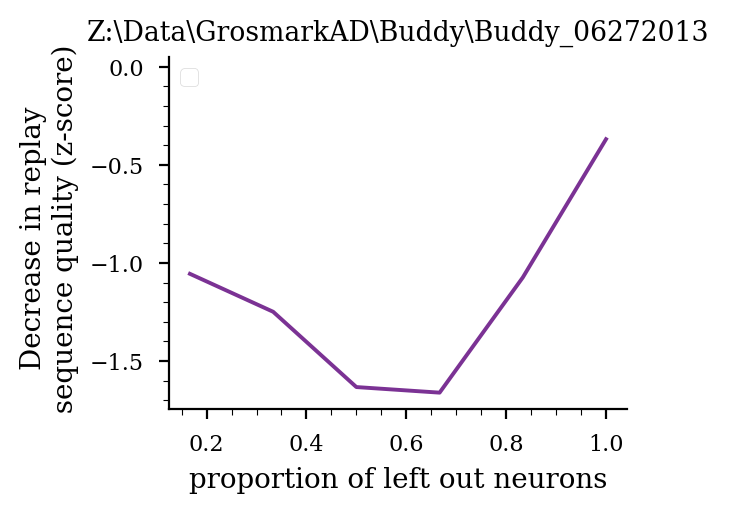

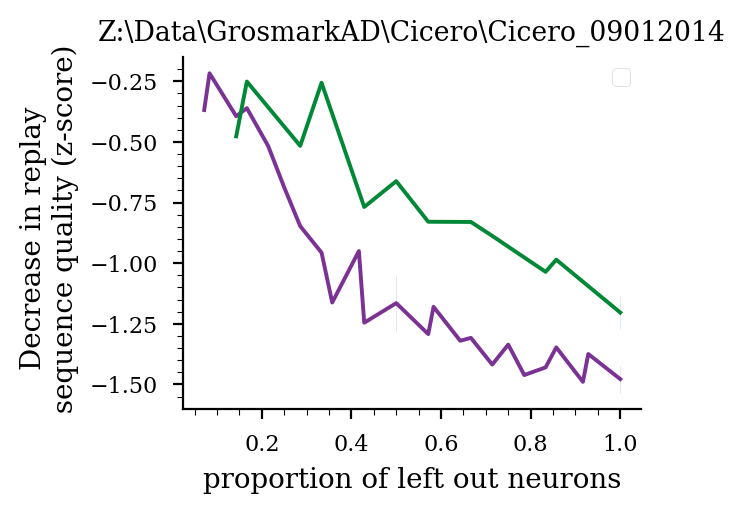

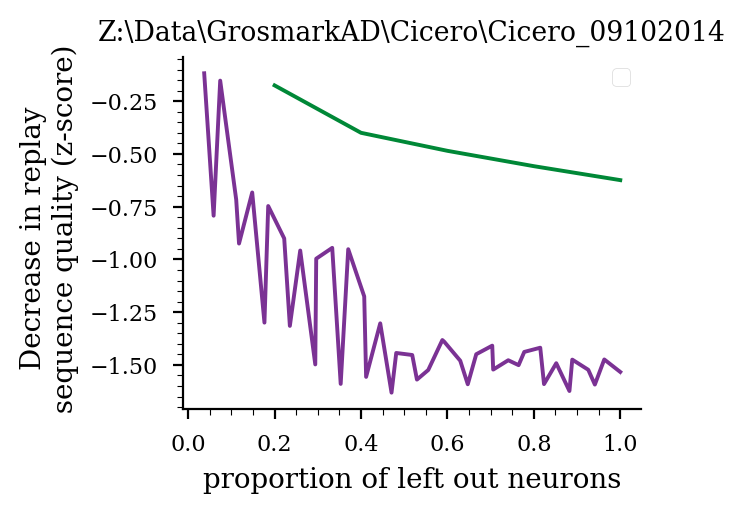

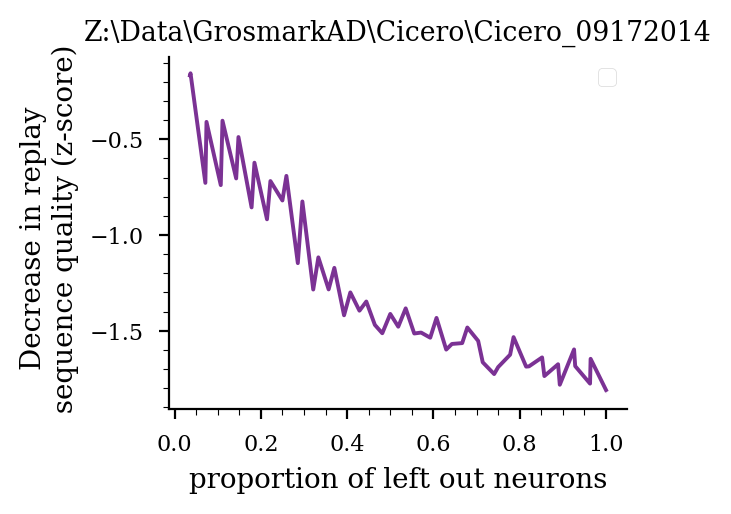

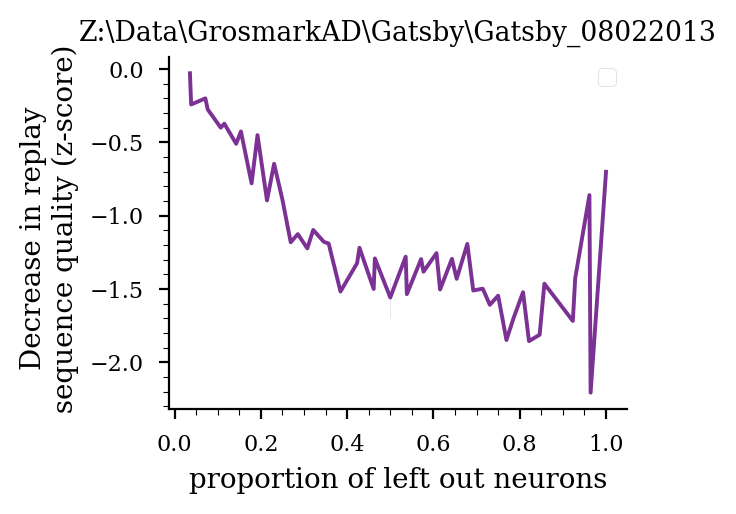

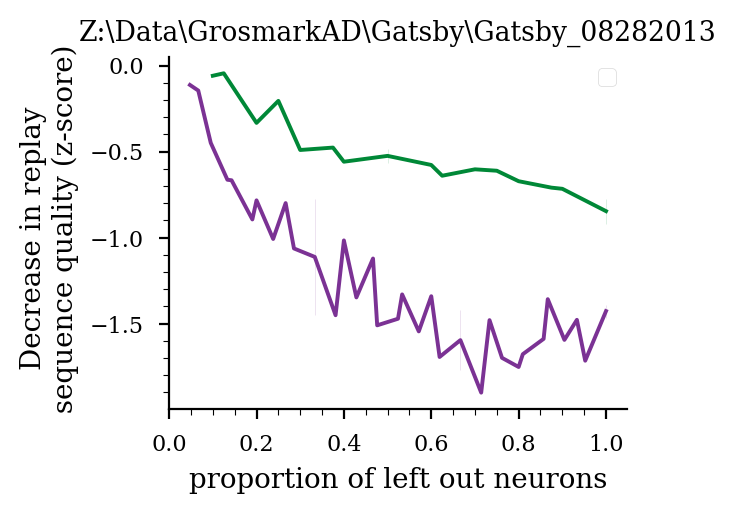

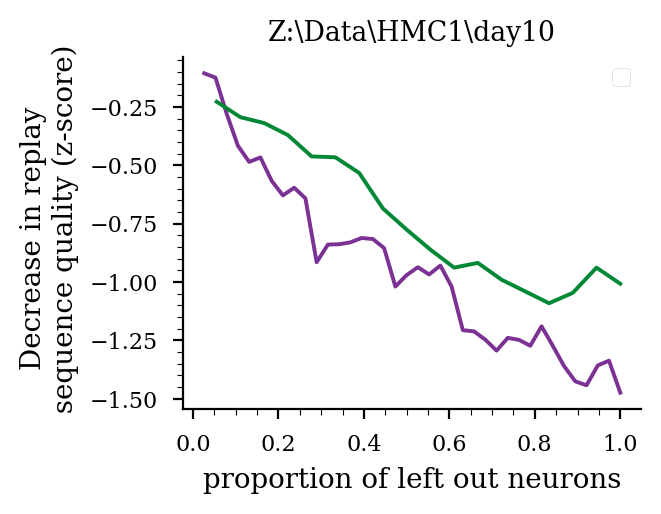

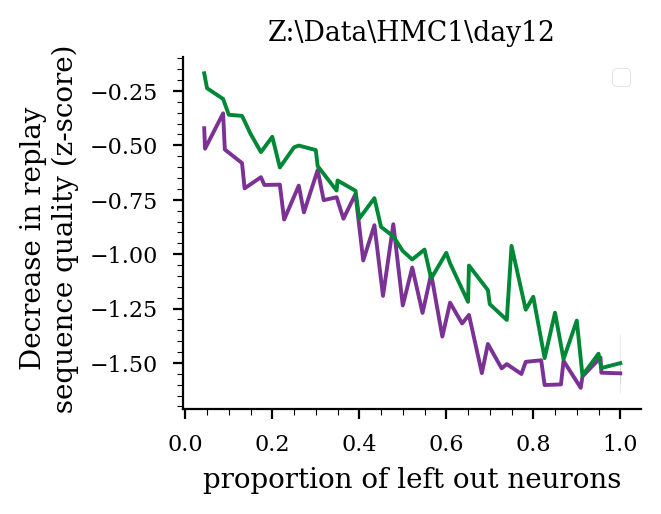

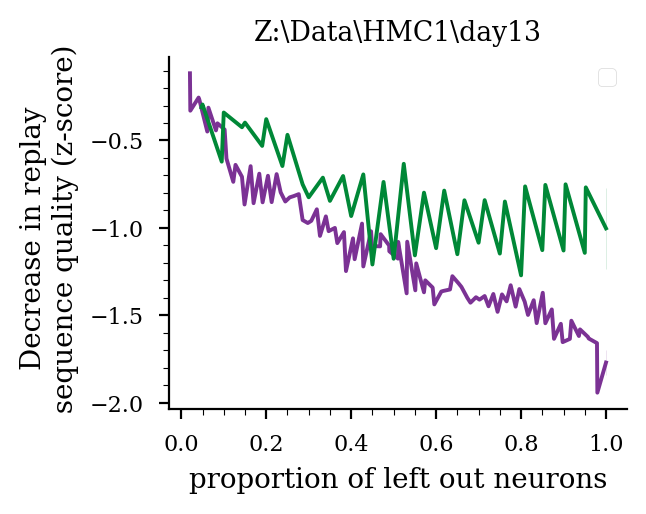

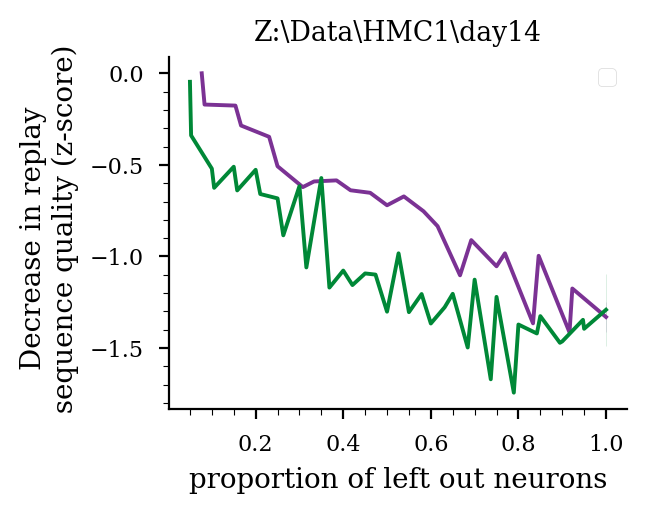

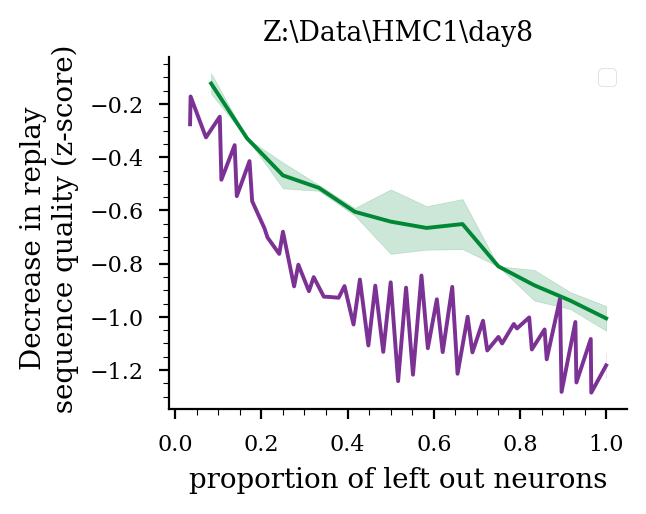

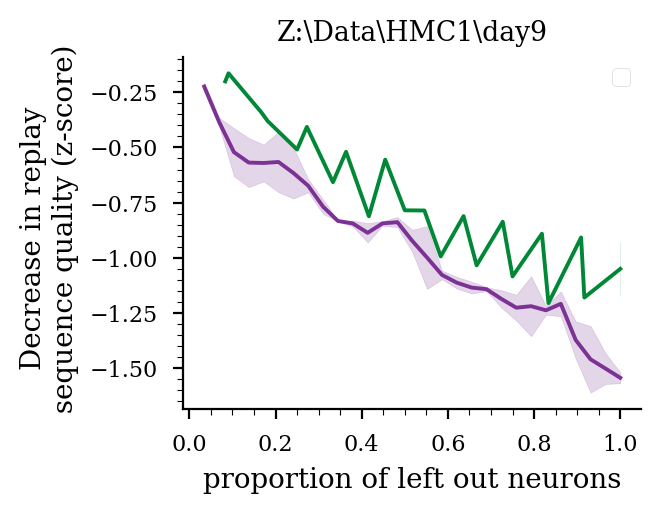

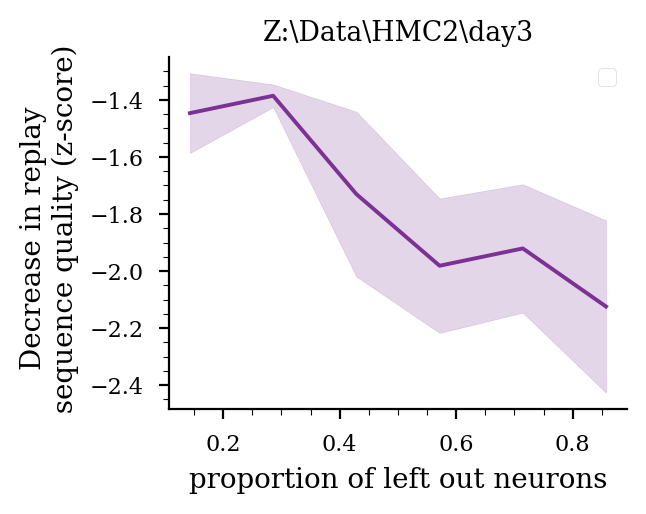

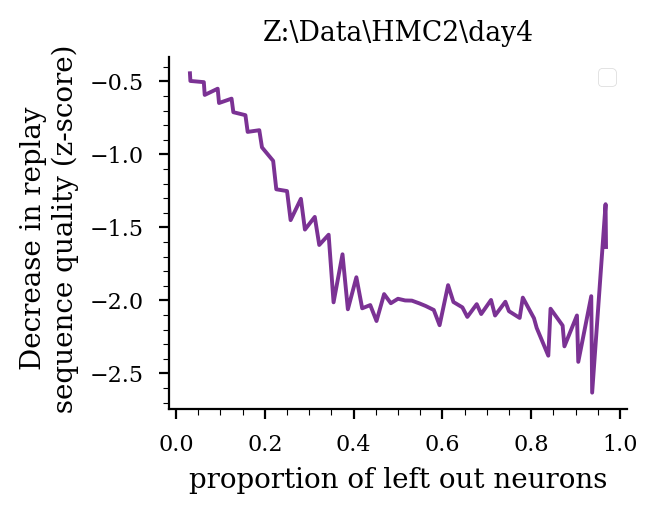

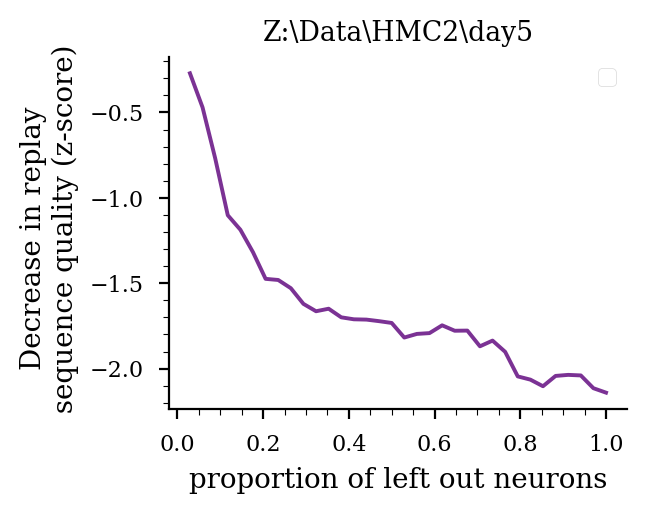

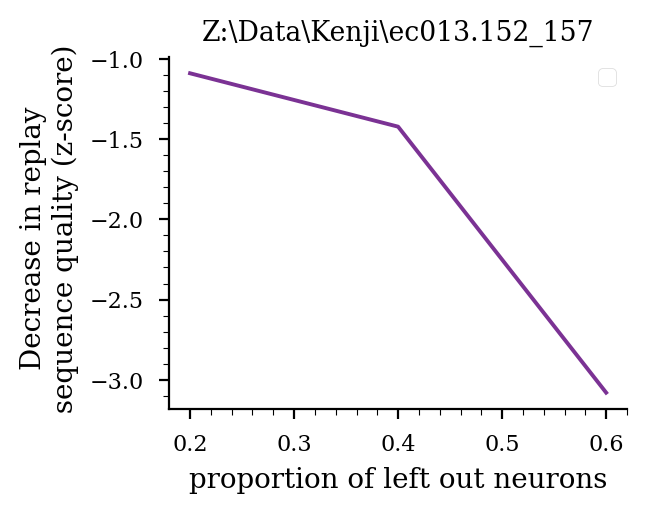

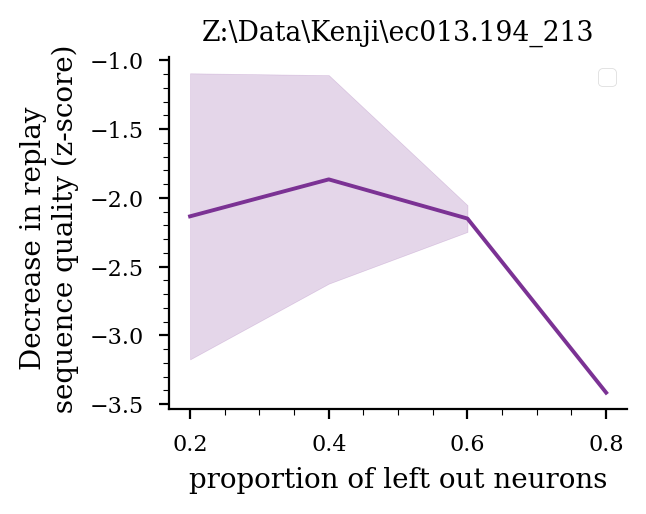

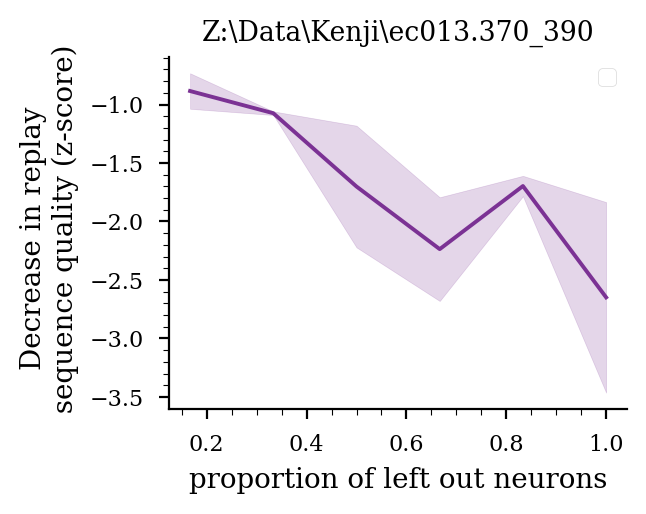

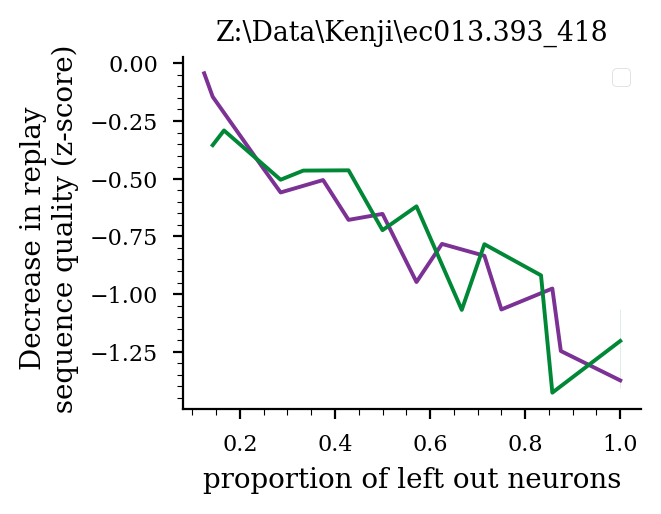

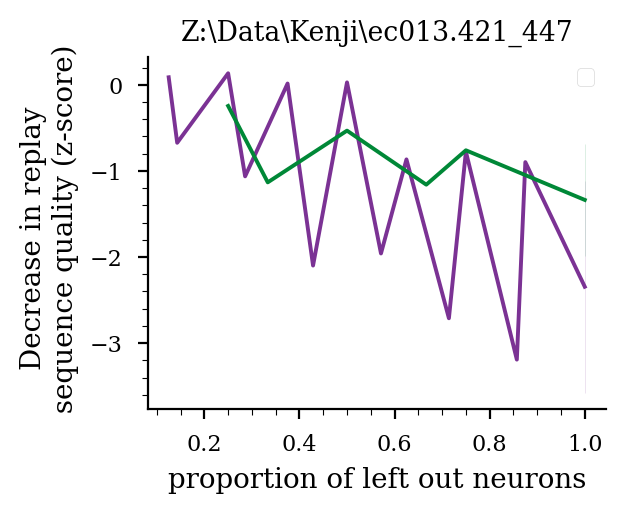

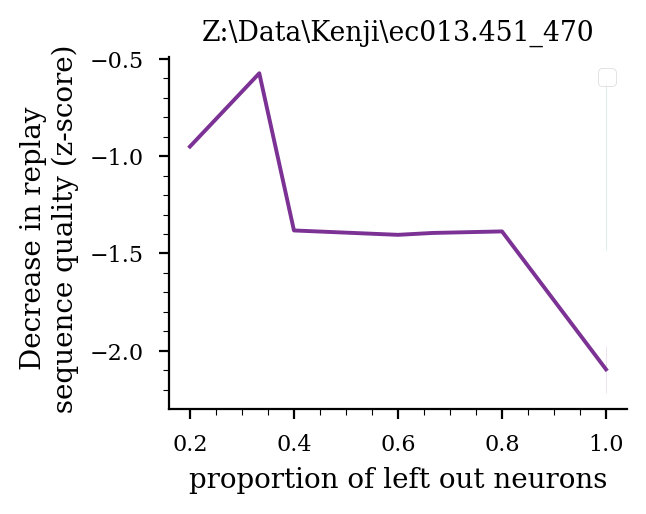

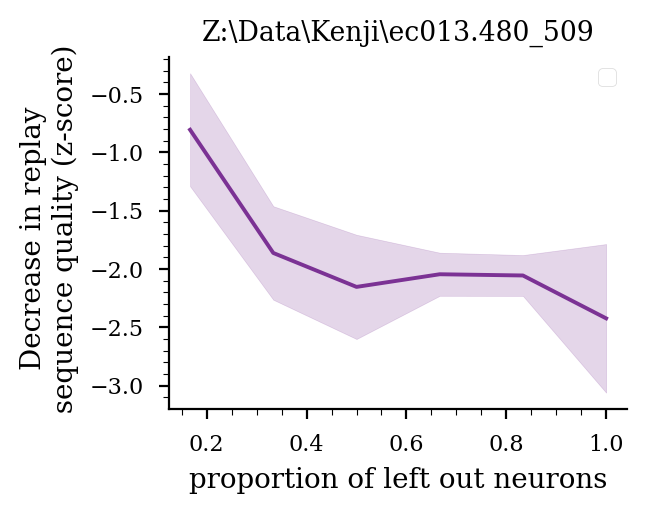

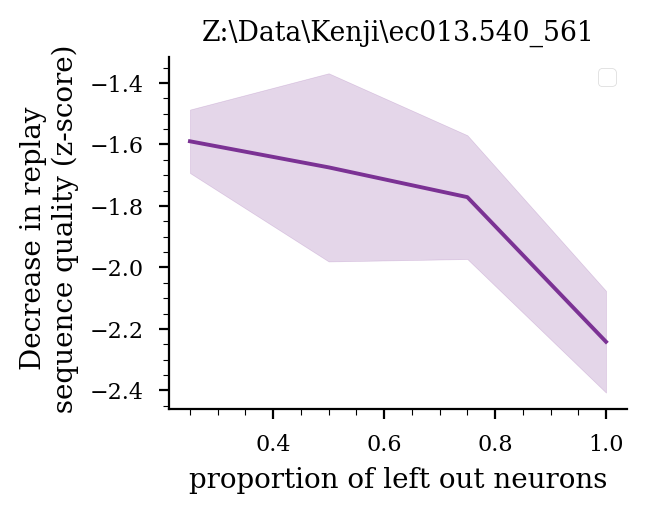

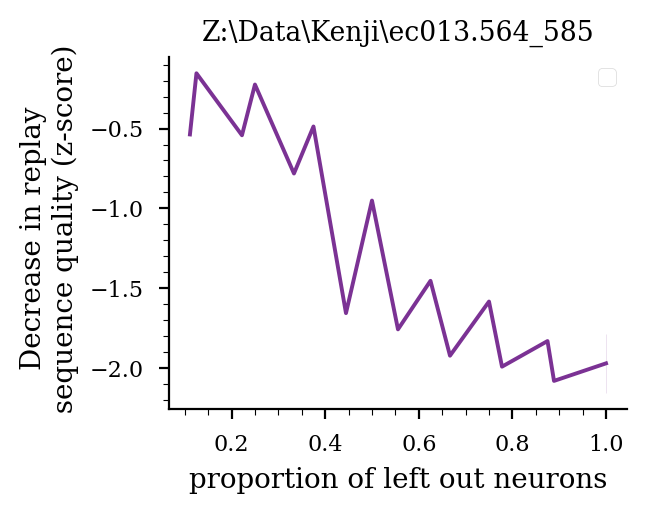

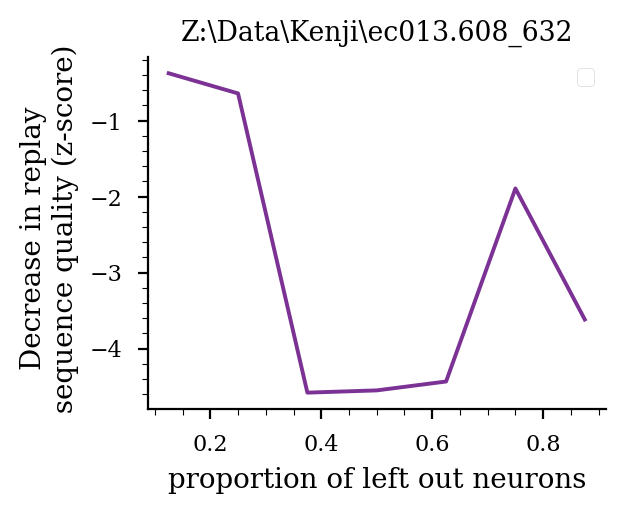

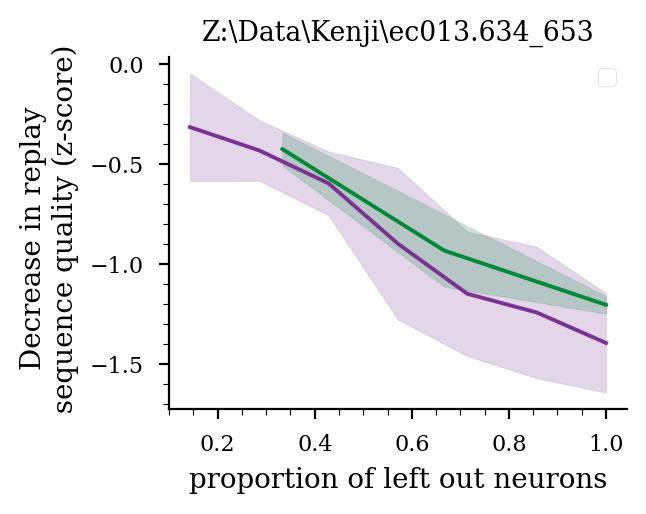

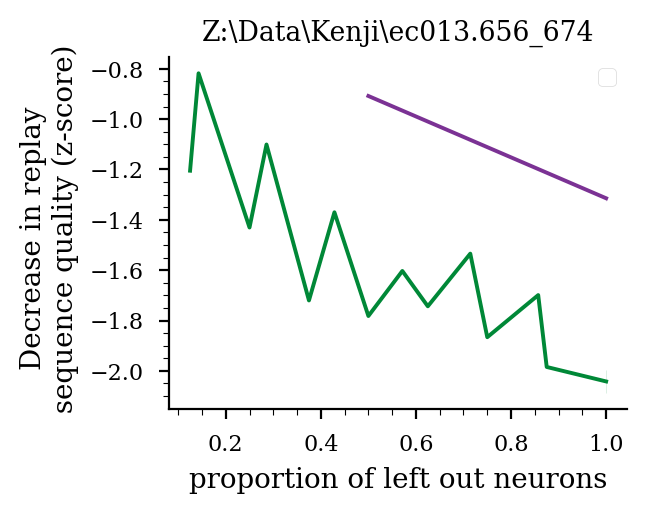

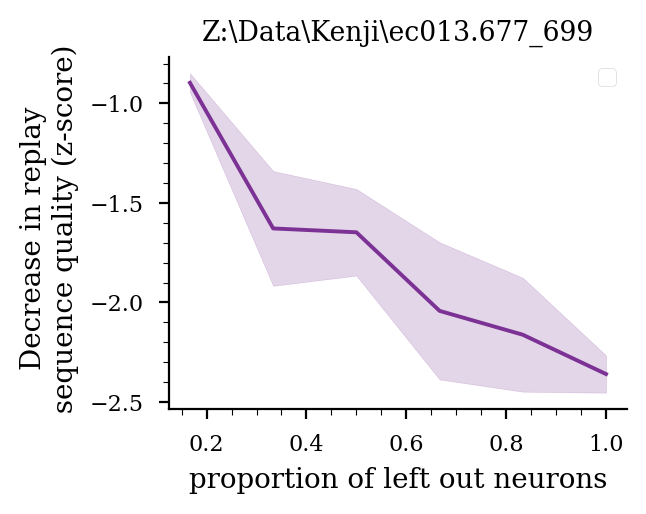

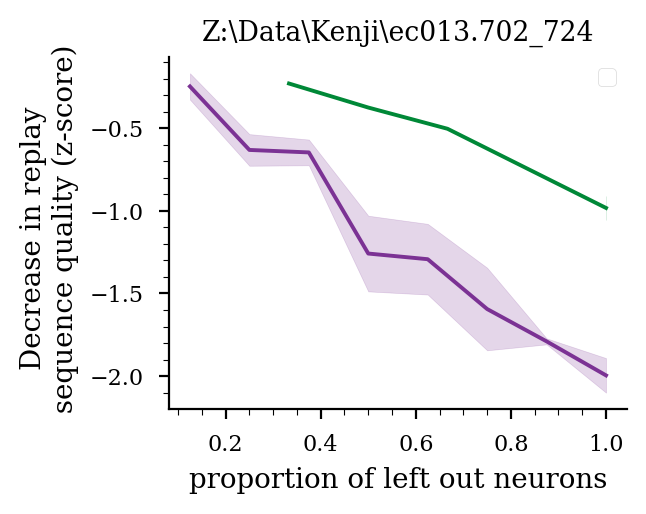

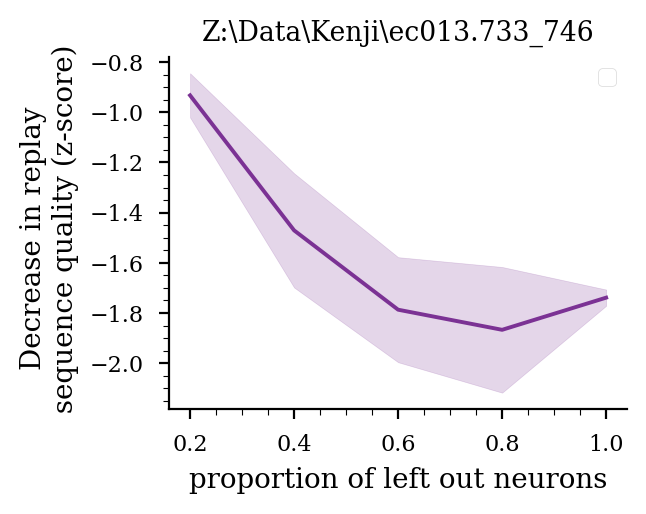

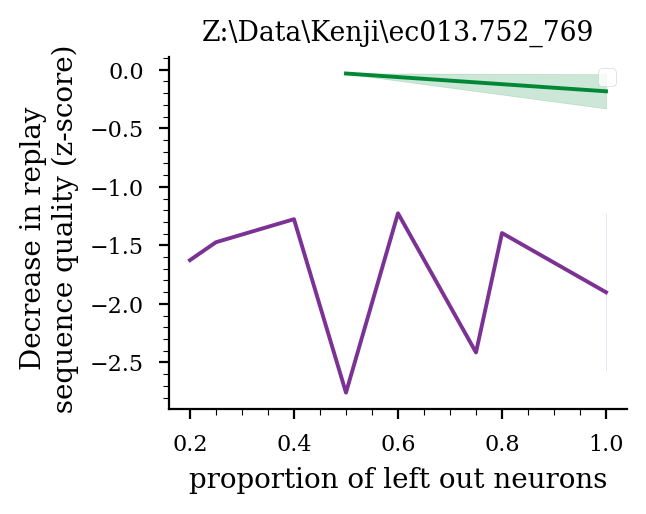

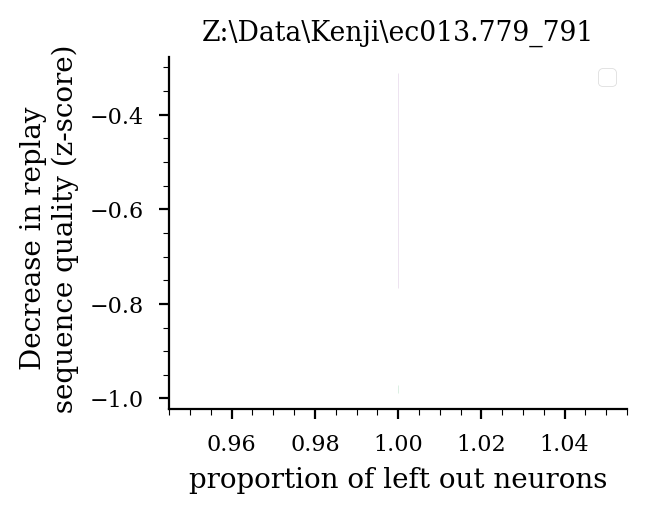

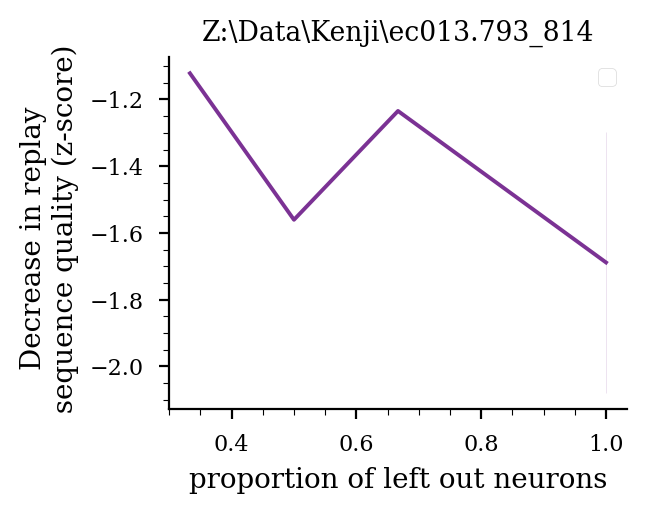

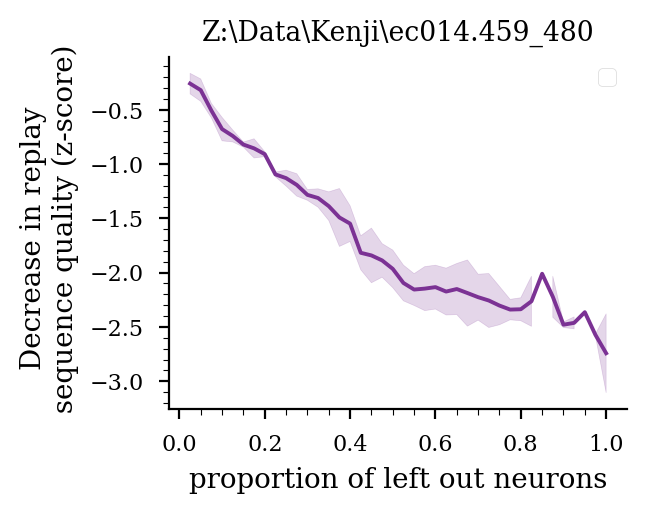

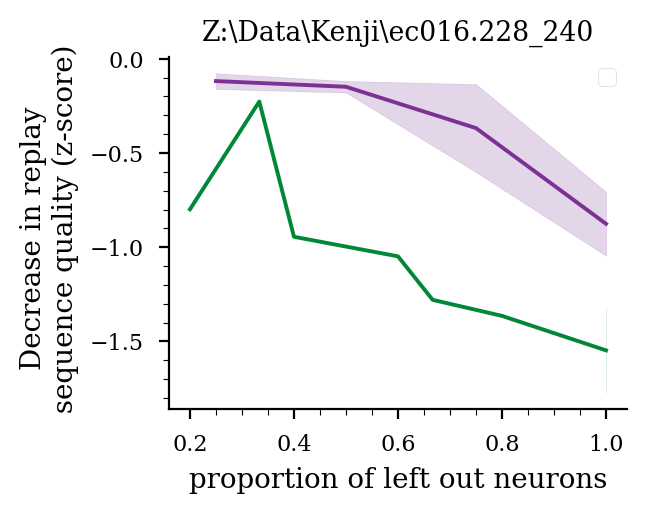

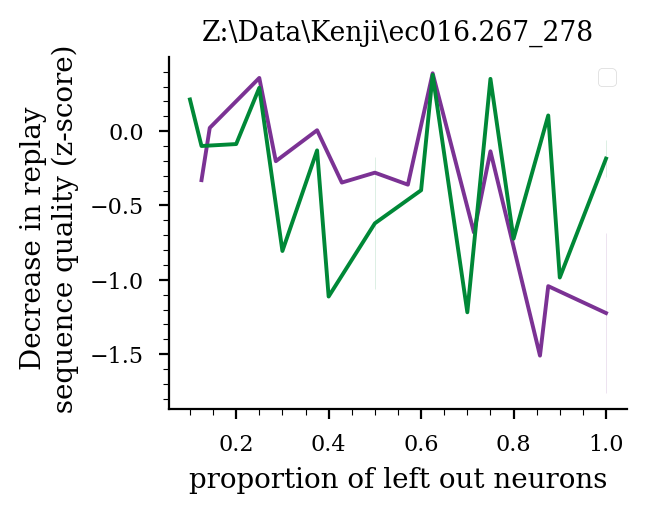

In [44]:
for basepath in results_df.basepath.unique():
    fig= plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1.25,1)), edgecolor=None)
    ax = plt.gca()

    sns.lineplot(data=results_df.query("basepath==@basepath"), x="n_dropped_norm", y="std_diff", hue="deepSuperficial",ax=ax)

    ax.set_xlabel("proportion of left out neurons")
    ax.set_ylabel("Decrease in replay \n sequence quality (z-score)")
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.legend("")
    sns.despine()
    ax.set_title(basepath)
    plt.show()

## Testing below

In [9]:
epoch_df = pd.DataFrame()
for basepath in df.basepath.unique():
    epoch_df_ = loading.load_epoch(basepath)
    epoch_df_["basepath"] = basepath
    epoch_df = pd.concat([epoch_df,epoch_df_], ignore_index=True)

In [19]:
import re
basepaths = epoch_df.query("environment.str.contains('linear',flags=@re.IGNORECASE)").basepath.unique()

cell_metrics = loading.load_all_cell_metrics(basepaths)
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)
cell_metrics.deepSuperficial = cell_metrics.deepSuperficial.replace(np.nan,"unknown")


In [25]:
cell_metrics.query("deepSuperficial.str.contains('Superficial')")[["basepath","deepSuperficial"]].value_counts().reset_index().loc[0:25]

basepath deepSuperficial   0
0                    Z:\Data\AYAold\AB3\AB3_58_59     Superficial  75
1                       Z:\Data\AYAold\AYA6\day19     Superficial  60
2                       Z:\Data\AYAold\AYA9\day17     Superficial  48
3                       Z:\Data\AYAold\AYA6\day20     Superficial  44
4                     Z:\Data\Kenji\ec013.656_674     Superficial  43
5                       Z:\Data\AYAold\AYA6\day17     Superficial  42
6                              Z:\Data\HMC1\day13     Superficial  41
7                     Z:\Data\Kenji\ec016.228_240     Superficial  40
8                              Z:\Data\HMC1\day12     Superficial  39
9                     Z:\Data\Kenji\ec014.628_645     Superficial  39
10                   Z:\Data\AYAold\AB3\AB3_38_41     Superficial  34
11                    Z:\Data\Kenji\ec016.267_278     Superficial  27
12                    Z:\Data\Kenji\ec013.677_699     Superficial  26
13        Z:\Data\GirardeauG\Rat08\Rat08-20130712     Superficial  25
14                             Z:\Data\HMC1\day10     Superficial  25
15  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013     Superficial  24
16                             Z:\Data\HMC1\day14     Superficial  23
17                   Z:\Data\AYAold\AB3\AB3_42_46     Superficial  23
18                        Z:\Data\Kenji\2006-6-12     Superficial  22
19                    Z:\Data\Kenji\ec016.100_121     Superficial  22
20        Z:\Data\GirardeauG\Rat08\Rat08-20130713     Superficial  20
21                      Z:\Data\AYAold\AYA9\day12     Superficial  19
22                              Z:\Data\HMC1\day8     Superficial  18
23                         Z:\Data\Can\OML23\day3     Superficial  17
24        Z:\Data\GirardeauG\Rat08\Rat08-20130718     Superficial  15
25                  Z:\Data\OMLproject\OML18\day4     Superficial  15

In [95]:
basepath = r"Z:\Data\AYAold\AB3\AB3_58_59"
replay_save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622"

# locate saved replay file and load it
save_file = os.path.join(
    replay_save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
)
# load replay results
with open(save_file, "rb") as f:
    results = pickle.load(f)

# iterate over the two template types
results_df = pd.DataFrame()
for direction in ["inbound_epochs", "outbound_epochs"]:

    # locate significant replay events
    idx_replay = np.where(results[direction]["df"].score_pval_time_swap < 0.05)[0]

    bst = copy.deepcopy(results[direction]["bst_placecells"])
    tc = copy.deepcopy(results[direction]["tc"])

    # find observed score for each replay event
    obs_scores, scores_time_swap, scores_col_cycle = replay.trajectory_score_bst(
        bst[idx_replay],
        tc,
        w=3,
        n_shuffles=400,
        normalize=True,
    )
    _, pvals, std_obs = functions.get_significant_events(obs_scores,scores_time_swap)
    std_obs = np.nanmean(std_obs)
    obs_scores = np.nanmean(obs_scores)

    cell_metrics = results[direction]["cell_metrics"]

    # iterate over deep and superficial
    # in this loop, cells will be dropped one by one and replay quality will be assessed each time
    for deepSuperficial in ["Deep", "Superficial"]:

        bst = copy.deepcopy(results[direction]["bst_placecells"])
        tc = copy.deepcopy(results[direction]["tc"])

        units_ = np.array(bst.series_ids)[cell_metrics.deepSuperficial.values == deepSuperficial]

        scores = []
        n_dropped = []
        std_dropped = []
        for i, units_i in enumerate(units_):

            units = np.array(bst.series_ids).T

            tc = tc._unit_subset(units[units != units_i])
            bst = bst._unit_subset(units[units != units_i])

            n_dropped.append(i)

            if bst.isempty:
                scores.append(np.nan)
                continue

            scores_, scores_time_swap, scores_col_cycle = replay.trajectory_score_bst(
                bst[idx_replay],
                tc,
                w=3,
                n_shuffles=400,
                normalize=True,
            )
                
            _, pvals, std_dropped_ = functions.get_significant_events(scores_,scores_time_swap)
            std_dropped.append(np.nanmean(std_dropped_))
            scores.append(np.nanmean(scores_))

        temp_df = pd.DataFrame()
        temp_df["scores"] = scores
        temp_df["std_dropped"] = std_dropped
        temp_df["obs_scores"] = obs_scores
        temp_df["std_obs"] = std_obs
        temp_df["n_dropped"] = n_dropped
        # temp_df["UID"] = cell_metrics.UID.values
        temp_df["deepSuperficial"] = deepSuperficial
        temp_df["direction"] = direction

        results_df = pd.concat([results_df, temp_df], ignore_index=True)


In [102]:
results_df["score_diff"] = results_df.scores - results_df.obs_scores
results_df["std_diff"] = results_df.std_dropped - results_df.std_obs
results_df["n_dropped"] = results_df["n_dropped"] + 1


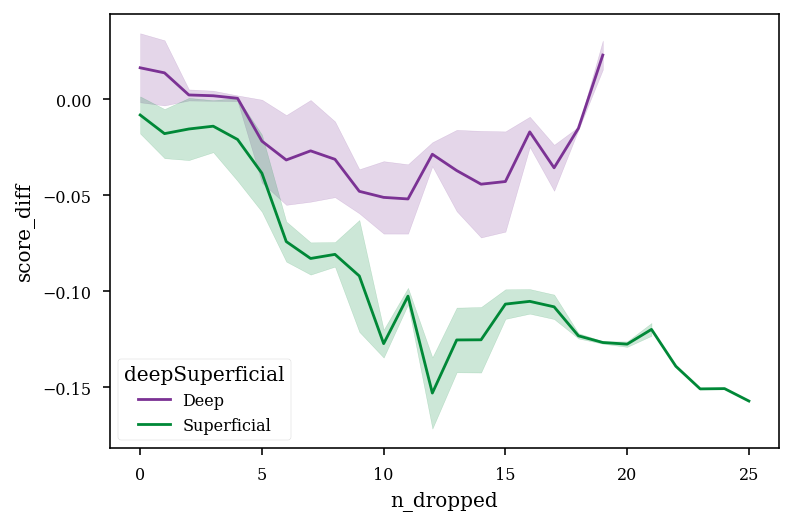

In [99]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.lineplot(data=results_df, x="n_dropped", y="score_diff", hue="deepSuperficial")
plt.show()

# sns.lineplot(data=results_df, x="n_dropped", y="std_diff", hue="deepSuperficial")
# plt.show()

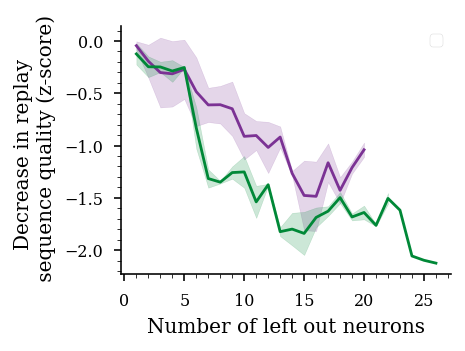

In [109]:
fig= plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1.25,1)), edgecolor=None)
ax = plt.gca()

sns.lineplot(data=results_df, x="n_dropped", y="std_diff", hue="deepSuperficial",ax=ax)

ax.set_xlabel("Number of left out neurons")
ax.set_ylabel("Decrease in replay \n sequence quality (z-score)")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.legend("")
sns.despine()
plt.show()